In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pylab
from pathlib import Path
import winsound
import xarray as xr
from e6dataflow.datamodel import load_datamodel
from e6dataflow.utils import shot_to_loop_and_point, scale_range
from e6dataflow.tools.fittools import e6_fit

In [2]:
datamodel_dir = Path.cwd()
fig_directory = Path(datamodel_dir, 'analysis_figures')
fig_data_directory = Path(datamodel_dir, 'analysis_figures_data')
fig_directory.mkdir(exist_ok=True)
fig_data_directory.mkdir(exist_ok=True)
datamodel = load_datamodel(run_name='run1', datamodel_name='datamodel_jag')
print('run_doc_string:\n' + datamodel.run_doc_string)

Loading datamodel from Y:\expdata-e6\analysis\2021\02\21\run1\datamodel_jag\run1-datamodel_jag.p
run_doc_string:
molasses freq = [4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]tweezer_freq_list = [108, 110, 112, 114, 116], 5 tweezers cav_odt_att_list = [0.2, 0.4, 0.6, 0.8, 1.0]pzt_list = [5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10]probe_att = 0no cavity modes, pzt_para = 5.5t_exposure = 500 ms , t_hold = 100 msphotoassociation -  drop cavity ODT - hold - load cavity ODT 


In [3]:
def freq_volt_to_baredet(freq_volt):
    # Returning detuning in MHz
    return freq_volt * 13.69 - 126.4
def freq_volt_to_det(freq_volt, tweezer_det):
    # Returning detuning in MHz
    return freq_volt_to_baredet(freq_volt) - tweezer_det

In [4]:
# Run information
mol_freq_list = [4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9]
mol_freq_list = freq_volt_to_baredet(np.array(mol_freq_list))
gamma = 6.07
tweezer_det = 5.88*gamma
mol_freq_list_wrt_tweezer = mol_freq_list - tweezer_det
num_mol_freq = len(mol_freq_list)
num_frames = num_mol_freq + 2 # One extra frame for post-selection of final frame, one reference frame.

tweezer_list = [108, 110, 112, 114, 116]
num_tweezer = len(tweezer_list)

pzt_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
num_pzt = len(pzt_list)

odt_att_list = [0.2, 0.4, 0.6, 0.8, 1]
num_odt_att = len(odt_att_list)

num_points = datamodel.num_points
num_shots = datamodel.num_handled_shots
num_loops_complete = num_shots // num_points

print(num_points, 'points')
print(num_frames, 'frames')
print(num_tweezer, 'tweezers')
print(num_shots, 'shots')
print(num_loops_complete, 'complete loops')
if num_shots % num_points != 0:
    num_loops = num_loops_complete + 1
    print('1 incomplete loop')
else:
    num_loops = num_loops_complete
    print('0 incomplete loops')


coords_list = [('loop', range(num_loops)),
               ('mol_freq', mol_freq_list),
               ('tweezer', tweezer_list),
               ('pzt', pzt_list),
               ('odt_att', odt_att_list)]

50 points
12 frames
5 tweezers
8825 shots
176 complete loops
1 incomplete loop


In [5]:
def frame_tweezer_key(frame_num, tweezer_num):
    return f'frame-{frame_num:02d}_tweezer-{tweezer_num:02d}'

def pzt_and_odt_to_point(pzt_num, odt_num, num_pzt, num_odt):
    if odt_num >= num_odt:
        raise ValueError('odt_num cannot exceed num_odt')
    if pzt_num >= num_pzt:
        raise ValueError('pzt_num cannot exceed num_pzt')        
    return pzt_num * num_odt + odt_num

def point_to_pzt_and_odt(point_num, num_pzt, num_odt):
    pzt_num = point_num // num_odt
    odt_num = point_num % num_odt
    return pzt_num, odt_num

def gaussian(x, x0, amp, sigma):
    return amp * np.exp(-(1 / 2) * (x - x0)**2 / sigma**2)

def double_gaussian(x, x0_1, amp_1, sigma_1, x0_2, amp_2, sigma_2):
    return gaussian(x, x0_1, amp_1, sigma_1) + gaussian(x, x0_2, amp_2, sigma_2)

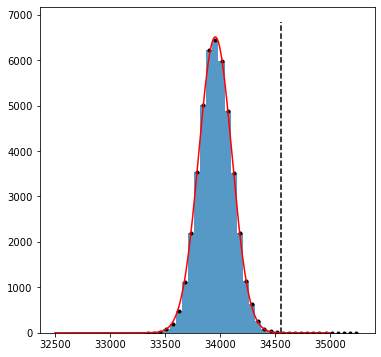

Reference data centered at 33956 counts with standard deviation 150
3-sigma threshold at 34557


In [6]:
# Analyze reference frame
ref_frame_num = 11
ref_counts_list = []
for tweezer_num in range(num_tweezer):
    data_key = frame_tweezer_key(ref_frame_num, tweezer_num)
    data_key = f'{data_key}_counts'
    ref_counts_data = datamodel.get_data(data_key, data_index='all')
    ref_counts_list += list(ref_counts_data)

fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(1, 1, 1)
n, bins, patches = ax.hist(ref_counts_list, bins=35, alpha=0.75)
bin_centers = (bins[1:] + bins[:-1]) / 2

ax.plot(bin_centers, n, '.', color='black')

fit_dict = e6_fit(output_data=n, input_data=bin_centers, fit_func=gaussian, 
                  param_guess=[19000, 40, 5000],
                  param_keys=['x0', 'amp', 'sigma'])

model_input = np.linspace(32500, 35000, 1000)
model_output = gaussian(model_input, *fit_dict['kwargs'].values())
ax.plot(model_input, model_output, color='red')

ref_center = fit_dict['x0']['val']
ref_sigma = np.abs(fit_dict['sigma']['val'])
ref_threshold = ref_center +4 * ref_sigma
ax.vlines(ref_threshold, 0, ax.get_ylim()[1], linestyle='--')
plt.show()
print(f'Reference data centered at {ref_center:.0f} counts with standard deviation {ref_sigma:.0f}')
print(f'3-sigma threshold at {ref_threshold:.0f}')

In [7]:
brightness_xr = xr.DataArray(coords=coords_list)

for shot_num in range(num_shots):
    if shot_num % 500 == 0:
        print(shot_num)
    for freq_num in range(num_mol_freq):
        for tweezer_num in range(num_tweezer):
            loop_num, point_num = shot_to_loop_and_point(shot_num, num_points=num_points)
            pzt_num, odt_att_num = point_to_pzt_and_odt(point_num, num_pzt, num_odt_att)
#             title_key = (f'freq_num: {freq_num}, odt_att_num: {odt_att_num}, '
#                          f'tweezer_num: {tweezer_num}, pzt_num: {pzt_num}, '
#                          f'point_num: {point_num}, loop_num: {loop_num}')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            data = datamodel.get_data(f'{data_key}_counts', data_index=shot_num)
            next_data_key = frame_tweezer_key(frame_num=freq_num + 1, tweezer_num=tweezer_num)
            next_data = datamodel.get_data(f'{next_data_key}_counts', data_index=shot_num)
            if data > ref_center + 1 * ref_sigma and next_data > ref_center + 3 * ref_sigma:
                brightness_xr[loop_num, freq_num, tweezer_num, pzt_num, odt_att_num] = data - ref_center

winsound.PlaySound("SystemAsterisk", winsound.SND_ALIAS)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


In [8]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

1770
1770
1770
1770


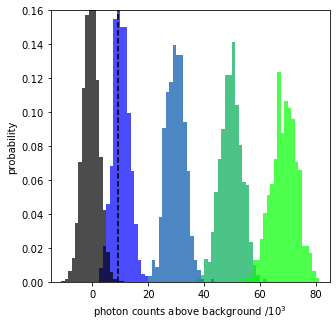

In [9]:
next_para = 3
this_para = 1
plot_range = (-15,85)
plot_range_abs = plot_range[1] - plot_range[0]
plot_range_abs = 80
camera_adu_conversion = 1000 / 0.28 
path_efficiency_estimate = 0.014
color_list = [(0, element/3, 1-element/3) for element in range(0,4)]
# print(ref_center)

freq_select = [0,6,8,9]  
freq_next_select = [1,7,9,10]
        
hist_dat_out_array = np.empty((plot_range_abs+2, 6), dtype=object)
hist_dat_out_array[0,0] = "bins(photon_counts/10^3)"
hist_dat_out_array[0,1] = "hist_ref"
for freq_counter, freq_num in enumerate(freq_select):
    hist_dat_out_array[0,freq_counter+2] = f"hist_atom(mol_freq={mol_freq_list[freq_num]})"

for odt_att_num in range(0, 1):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(5, 5))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
#         dat_out_dict = {}
        for freq_counter, freq_num in enumerate(freq_select):
            if freq_counter > 1:
                this_para = 4
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            next_data_key = frame_tweezer_key(frame_num=freq_next_select[freq_counter], tweezer_num=tweezer_num)
            data_post_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num)) - ref_center
                next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num))- ref_center
                data_post = data[np .logical_and(data > this_para * ref_sigma, next_data > next_para * ref_sigma)]/(camera_adu_conversion*path_efficiency_estimate)
                data_post_all = np.append(data_post_all, data_post)
#             
            
#             n, bins, patches = ax_hist.hist(data_post_all*camera_adu_conversion, bins=int((max(data_post_all)-min(data_post_all))/70), \
#                                             color=color_list[freq_counter], alpha=0.7)
            n, bins, patches = ax_hist.hist(data_post_all, bins=plot_range_abs, \
                                            range=plot_range, color=color_list[freq_counter], alpha=0.7)

            hist_dat_out_array[2:,freq_counter+2] = n/sum(n)
#             print([len(n),len(bins)])
#             dat_out_dict[f'mol_freq_det={mol_freq_list[freq_num]}'] = data_post_all
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)
            for item in patches:
                item.set_height(item.get_height()/sum(n))
            print(num_pzt*num_loops)
        data_key = frame_tweezer_key(ref_frame_num, tweezer_num=tweezer_num)
        ref_counts_data = (datamodel.get_data(f'{data_key}_counts', data_index='all') - ref_center)/(camera_adu_conversion*path_efficiency_estimate)
        n, bins, patches = ax_hist.hist(ref_counts_data, bins=plot_range_abs, \
                                            range=plot_range, color='black', alpha=0.7)
        hist_dat_out_array[1:,0] = bins
        hist_dat_out_array[2:,1] = n/sum(n)
#         dat_out_dict[f'reference_frame'] = ref_counts_data
        for item in patches:
            item.set_height(item.get_height()/sum(n))

#         fig.suptitle(title_key)
        ax_hist.set_xlim(plot_range)
        ax_hist.set_ylim(0, 0.16)
        ax_hist.vlines(next_para*ref_sigma /(camera_adu_conversion*path_efficiency_estimate), 0, ax_hist.get_ylim()[1], linestyle='--')

        ax_hist.set_ylabel('probability')
        ax_hist.set_xlabel('photon counts above background $/10^3$')
            
#         if tweezer_num == 4:
        plt.show()
        save_dir = Path(fig_directory)
        save_dir.mkdir(parents=True, exist_ok=True)
        file_name = f'figure - 2a - withref.png'
        file_path = Path(save_dir, file_name)
        fig.savefig(file_path, dpi=500)
        plt.close(fig)
        
        fig_data_directory = Path(datamodel_dir, 'analysis_figures_data')
        
        
import csv  
save_data_dir = Path(fig_data_directory)
file_name = 'figure-2a_data.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in hist_dat_out_array:
        csv_writer.writerow(row)
#         import csv
#         save_data_dir = Path(fig_data_directory)
#         file_name = 'figure - 2a - withref.txt'
#         dat_file_path = Path(save_data_dir, file_name)
#         with open(dat_file_path, 'w') as csv_file:
#             csv_writer = csv.writer(csv_file, delimiter=',')
#             csv_writer0 = csv.writer(csv_file, delimiter=' ')
            
#             csv_writer0.writerow('histogram information: bin_width=1, total shot number = 1770')
#             csv_writer0.writerow('\r\n')
#             for key in dat_out_dict:
#                 csv_writer0.writerow(key)
#                 csv_writer.writerow(dat_out_dict[key])
#                 csv_writer0.writerow('\r\n')

1770
1770
1770


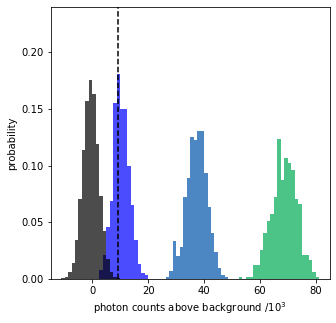

In [10]:
next_para = 3
this_para = 1
plot_range = (-15,85)
plot_range_abs = plot_range[1] - plot_range[0]
plot_range_abs = 80
camera_adu_conversion = 1000 / 0.28 
path_efficiency_estimate = 0.014
color_list = [(0, element/3, 1-element/3) for element in range(0,4)]
# print(ref_center)

freq_select = [0,7,9]  
freq_next_select = [1,8,10]
        
hist_dat_out_array = np.empty((plot_range_abs+2, len(freq_select)+2), dtype=object)
hist_dat_out_array[0,0] = "bins(photon_counts/10^3)"
hist_dat_out_array[0,1] = "hist_ref"
for freq_counter, freq_num in enumerate(freq_select):
    hist_dat_out_array[0,freq_counter+2] = f"hist_atom(mol_freq={mol_freq_list[freq_num]})"

for odt_att_num in range(0, 1):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(5, 5))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
#         dat_out_dict = {}
        for freq_counter, freq_num in enumerate(freq_select):
            if freq_counter > 1:
                this_para = 4
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            next_data_key = frame_tweezer_key(frame_num=freq_next_select[freq_counter], tweezer_num=tweezer_num)
            data_post_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num)) - ref_center
                next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num))- ref_center
                data_post = data[np .logical_and(data > this_para * ref_sigma, next_data > next_para * ref_sigma)]/(camera_adu_conversion*path_efficiency_estimate)
                data_post_all = np.append(data_post_all, data_post)
#             
            
#             n, bins, patches = ax_hist.hist(data_post_all*camera_adu_conversion, bins=int((max(data_post_all)-min(data_post_all))/70), \
#                                             color=color_list[freq_counter], alpha=0.7)
            n, bins, patches = ax_hist.hist(data_post_all, bins=plot_range_abs, \
                                            range=plot_range, color=color_list[freq_counter], alpha=0.7)

            hist_dat_out_array[2:,freq_counter+2] = n/sum(n)
#             print([len(n),len(bins)])
#             dat_out_dict[f'mol_freq_det={mol_freq_list[freq_num]}'] = data_post_all
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)
            for item in patches:
                item.set_height(item.get_height()/sum(n))
            print(num_pzt*num_loops)
        data_key = frame_tweezer_key(ref_frame_num, tweezer_num=tweezer_num)
        ref_counts_data = (datamodel.get_data(f'{data_key}_counts', data_index='all') - ref_center)/(camera_adu_conversion*path_efficiency_estimate)
        n, bins, patches = ax_hist.hist(ref_counts_data, bins=plot_range_abs, \
                                            range=plot_range, color='black', alpha=0.7)
        hist_dat_out_array[1:,0] = bins
        hist_dat_out_array[2:,1] = n/sum(n)
#         dat_out_dict[f'reference_frame'] = ref_counts_data
        for item in patches:
            item.set_height(item.get_height()/sum(n))

#         fig.suptitle(title_key)
        ax_hist.set_xlim(plot_range)
        ax_hist.set_ylim(0, 0.24)
        ax_hist.vlines(next_para*ref_sigma /(camera_adu_conversion*path_efficiency_estimate), 0, ax_hist.get_ylim()[1], linestyle='--')

        ax_hist.set_ylabel('probability')
        ax_hist.set_xlabel('photon counts above background $/10^3$')
            
#         if tweezer_num == 4:
        plt.show()
        save_dir = Path(fig_directory)
        save_dir.mkdir(parents=True, exist_ok=True)
        file_name = f'figure - 2a - withref.png'
        file_path = Path(save_dir, file_name)
        fig.savefig(file_path, dpi=500)
        plt.close(fig)
        
        fig_data_directory = Path(datamodel_dir, 'analysis_figures_data')
        
        
import csv  
save_data_dir = Path(fig_data_directory)
file_name = 'figure-2a_other_data.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in hist_dat_out_array:
        csv_writer.writerow(row)
#         import csv
#         save_data_dir = Path(fig_data_directory)
#         file_name = 'figure - 2a - withref.txt'
#         dat_file_path = Path(save_data_dir, file_name)
#         with open(dat_file_path, 'w') as csv_file:
#             csv_writer = csv.writer(csv_file, delimiter=',')
#             csv_writer0 = csv.writer(csv_file, delimiter=' ')
            
#             csv_writer0.writerow('histogram information: bin_width=1, total shot number = 1770')
#             csv_writer0.writerow('\r\n')
#             for key in dat_out_dict:
#                 csv_writer0.writerow(key)
#                 csv_writer.writerow(dat_out_dict[key])
#                 csv_writer0.writerow('\r\n')

In [11]:
int(plot_range_abs)

80

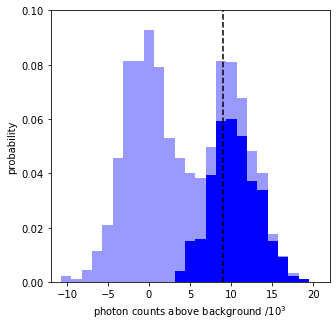

In [12]:
next_para = 3
this_para = 1
plot_range = (-12,22)
plot_range_abs = int((plot_range[1] - plot_range[0])*0.8)
camera_adu_conversion = 1000 / 0.28 
path_efficiency_estimate = 0.014
color_list = ['blue', 'cyan']
        
hist_dat_out_array = np.empty((plot_range_abs+2, 3), dtype=object)
hist_dat_out_array[0,0] = "bins(photon_counts/10^3)"
hist_dat_out_array[0,1] = "hist_atom(pre_selected)"
hist_dat_out_array[0,2] = "hist_atom(post_selected)"

for odt_att_num in range(0,1):
    for tweezer_num in range(3,4):
        fig = plt.figure(figsize=(5, 5))
        ax_hist = fig.add_subplot(1, 1, 1)
        
#         for freq_num in range(0,num_mol_freq,2):             
        freq_select = [0]       
        freq_next_select = [1]        
#         dat_out_dict = {}
        for freq_counter, freq_num in enumerate(freq_select):             
            title_key = (f'odt_num: {odt_att_num} - '
                         f'tweezer_num: {tweezer_num}, ')
            data_key = frame_tweezer_key(frame_num=freq_num, tweezer_num=tweezer_num)
            data_post_all = np.array([])
            data_all = np.array([])
            for pzt_num in range(num_pzt):
                point_num = pzt_and_odt_to_point(pzt_num, odt_att_num, num_pzt, num_odt_att)
                data = np.array(datamodel.get_data_by_point(f'{data_key}_counts', point_num=point_num)) - ref_center
#                 next_data_key = frame_tweezer_key(frame_num=freq_num + 1, tweezer_num=tweezer_num)
                next_data_key = frame_tweezer_key(frame_num=freq_next_select[freq_counter], tweezer_num=tweezer_num)
                next_data = np.array(datamodel.get_data_by_point(f'{next_data_key}_counts', point_num=point_num)) - ref_center
                data_post = data[np .logical_and(data > this_para * ref_sigma, next_data > next_para * ref_sigma)]
                data_all = np.append(data_all, data/(camera_adu_conversion*path_efficiency_estimate))
                data_post_all = np.append(data_post_all, data_post/(camera_adu_conversion*path_efficiency_estimate))
#             data_post_2 = np.copy(data)
#             data_post_2[np.logical_or(data < ref_center + 1 * ref_sigma, next_data < ref_center + 3 * ref_sigma)] = np.nan
            
            
#             dat_out_dict[f'mol_freq_det={mol_freq_list[freq_num]}_raw'] = data_all
            n, bins, patches = ax_hist.hist(data_all, bins=plot_range_abs, \
                                            range=plot_range,   color  = color_list[freq_counter], alpha=0.4, label = f'{mol_freq_list[freq_num]/gamma:.1f} (raw data)')
            normalize = sum(n)
            hist_dat_out_array[1:,0] = bins
            hist_dat_out_array[2:,1] = n/normalize
        
            for item in patches:
                item.set_height(item.get_height()/(num_pzt*num_loops))
                
#             dat_out_dict[f'mol_freq_det={mol_freq_list[freq_num]}_post_selected'] = data_post_all
            n, bins, patches = ax_hist.hist(data_post_all, bins=plot_range_abs, \
                                            range=plot_range, color  = color_list[freq_counter], alpha=1, label = f'{mol_freq_list[freq_num]/gamma:.1f} (post selected)')
            
            hist_dat_out_array[2:,2] = n/normalize
#             ax_hist.hist(data_post, color='black', bins=bins, alpha=0.5)

            for item in patches:
                item.set_height(item.get_height()/(num_pzt*num_loops))
#         data_key = frame_tweezer_key(ref_frame_num, tweezer_num=tweezer_num)
#         ref_counts_data = datamodel.get_data(f'{data_key}_counts', data_index='all') - ref_center
#         n, bins, patches = ax_hist.hist(ref_counts_data*camera_adu_conversion, bins=30, \
#                                             range=(-2,4), color='black', alpha=0.7, density=True)
#         for item in patches:
#             item.set_height(item.get_height()/sum(n))
#         fig.suptitle(title_key)
        ax_hist.set_xlim(plot_range)
        ax_hist.set_ylim(0, 0.1)
        ax_hist.vlines(next_para * ref_sigma/(camera_adu_conversion*path_efficiency_estimate), 0, ax_hist.get_ylim()[1], linestyle='--')
#         ax_hist.legend(title='Molasses bare detuning $\Delta/\Gamma$', bbox_to_anchor=(1, 1), loc='upper right')
        ax_hist.set_ylabel('probability')
        ax_hist.set_xlabel('photon counts above background $/10^3$')
            
            
#         if tweezer_num == 4:
        plt.show()
        save_dir = Path(fig_directory)
        save_dir.mkdir(parents=True, exist_ok=True)
        file_name = f'figure - 2a(inset).png'
        file_path = Path(save_dir, file_name)
        fig.savefig(file_path, dpi=500)
        plt.close(fig)
        
        fig_data_directory = Path(datamodel_dir, 'analysis_figures_data')
        
import csv  
save_data_dir = Path(fig_data_directory)
file_name = 'figure-2a(inset)_data.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in hist_dat_out_array:
        csv_writer.writerow(row)
#         import csv
#         save_data_dir = Path(fig_data_directory)
#         file_name = 'figure - 2a(inset).txt'
#         dat_file_path = Path(save_data_dir, file_name)
#         with open(dat_file_path, 'w') as csv_file:
#             csv_writer = csv.writer(csv_file, delimiter=',')
#             csv_writer0 = csv.writer(csv_file, delimiter=' ')
            
#             csv_writer0.writerow('histogram information: bin_width=1, total shot number = 1770')
#             csv_writer0.writerow('\r\n')
#             for key in dat_out_dict:
#                 csv_writer0.writerow(key)
#                 csv_writer.writerow(dat_out_dict[key])
#                 csv_writer0.writerow('\r\n')

In [13]:
def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2
def root_sum_square(*args):
    my_sum = 0
    for i in args:
        my_sum += i**2
    return np.sqrt(my_sum)

def bright_to_det(brightness, f0, amp):
    adjusted_brightness = brightness
    return -np.sqrt(amp / adjusted_brightness) + f0

def process_approach_curve(freq_list, brightness_list, brightness_err_list=None, ax=None):
    fit_dict = e6_fit(input_data=freq_list, output_data=brightness_list, fit_func=spectral_func,
                  param_guess=[32, 4200000], param_keys=['f0', 'amp'])
    
    min_freq = min(freq_list)
    max_freq = max(freq_list)
    max_freq = 20
    plot_range_min,  plot_range_max = scale_range(min_freq, max_freq, 1.1)
    
    model_input = np.linspace(plot_range_min, plot_range_max, 100)
    model_output = spectral_func(model_input, **fit_dict['kwargs'])
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    ax.errorbar(freq_list, brightness_list, brightness_err_list, linestyle='', marker='.', markersize=10)
    ax.plot(model_input, model_output)
    ax.vlines(fit_dict['f0']['val'], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])
    ax.set_ylim([0, 4000])
    print(*fit_dict['fit_results_string_list'], sep='\n')
#     print(f'freq_offset = {fit_dict["f0"]["val"]:.2f} +- {fit_dict["f0"]["std"]:.2f} MHz')
    return fit_dict

In [14]:
# dat_out_array = np.empty((len(freq_data)+1,num_odt_att+2), dtype=object)
# # dat_out_array[:] = " "
# dat_out_array[0,0] = "Delta/Gamma"
# for ii in range(6):
#     dat_out_array[0,ii+1] = "photon counts/10^3 (odt=0)"
    
# dat_out_array[1:,0] = freq_data.values

# print(fit_out_array)

NameError: name 'fit_out_array' is not defined

0
5.1291328589355345 $\pm$ 0.08626304387050947
1
3.911495707536123 $\pm$ 0.11612166915971367
2
2.3577459494344337 $\pm$ 0.08938752146540327
3
0.6456487751384071 $\pm$ 0.20779880234023435


c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


4
-0.6700963096573217 $\pm$ 0.32320514641940007


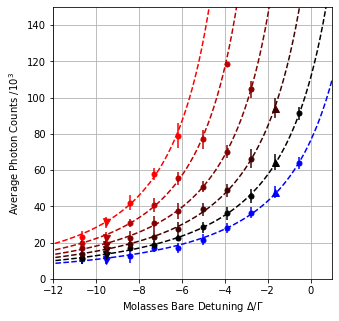

In [18]:
# Approach Curve Figure:
from scipy.optimize import curve_fit

def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2

camera_adu_conversion = 1000 / 0.28  # ADU/e-
path_efficiency_estimate = 0.014  # 6% NA, 70% Mitutoyo, 50% Path, 60% Andor
tau = 500e-3
gamma = 6.07

conversion_factor = camera_adu_conversion * path_efficiency_estimate 


tweezer_num = 2
pzt_num = 0
odt_att_num = 0
loop_start = 100
loop_stop = loop_start + 30

fig = plt.figure(figsize=(5.0, 5.0))
ax = fig.add_subplot(1, 1, 1)  
# dat_out_dict = {}

brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                     odt_att=odt_att_num,
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
freq_data = brightness_data.coords['mol_freq'] / (gamma)

dat_out_array = np.empty((len(freq_data)+1, 2*(num_odt_att+1)+1), dtype=object)
dat_out_array[0,0] = "Delta/Gamma"
for ii in range(6):
    dat_out_array[0,2*ii+1] = f"photon counts/10^3 (odt={ii})"
    dat_out_array[0,2*ii+2] = f"sigma_photon counts/10^3 (odt={ii})"

fit_out_array = np.empty((len(np.linspace(-13, 1, 100))+1, (num_odt_att+1)+1), dtype=object)
fit_out_array[0,0] = "Delta/Gamma"
for ii in range(6):
    fit_out_array[0,ii+1] = f"photon counts/10^3 (odt={ii})"

red_color = np.linspace(0, 1, num_odt_att)

brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                     odt_att=odt_att_num,
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
sigma_brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
brightness_data = brightness_data / conversion_factor
sigma_brightness_data = sigma_brightness_data / conversion_factor
freq_data = brightness_data.coords['mol_freq'] / (gamma)


mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)
    
popt, pcov = curve_fit(spectral_func, freq_data[mask], brightness_data[mask],\
                               sigma = sigma_brightness_data[mask], p0=[3,2500], maxfev = 10000)
ref_f0, ref_amp = popt
sigma_ref_amp = np.sqrt(pcov[1,1])
sigma_ref_f0 = np.sqrt(pcov[0,0])
model_freq = np.linspace(-13, 1, 100)
model_brightness = spectral_func(model_freq, ref_f0, ref_amp)

color = (red_color[odt_att_num], 0, 0)
other_freq = np.array([0,2,3,4,5,6,7,9])
# dat_out_dict[r'Molasses-Bare-Detuning-$\Delta/\Gamma$(odt=0)'] = freq_data.values
# dat_out_dict['Average-Photon-Counts-/$10^3$(odt=0)'] = brightness_data.values
# dat_out_dict['Error-of-Average-Photon-Counts-/$10^3$(odt=0)'] = sigma_brightness_data.values
dat_out_array[1:,0] = freq_data.values
dat_out_array[1:,1] = brightness_data.values
dat_out_array[1:,2] = sigma_brightness_data.values

fit_out_array[1:,0] = model_freq
fit_out_array[1:,1] = model_brightness

ax.errorbar(freq_data[other_freq], brightness_data[other_freq],\
            yerr = sigma_brightness_data[other_freq], linestyle='none', marker='.', markersize=10, color=(0, 0, 1),label = '0')
ax.errorbar(freq_data[1], brightness_data[1],\
            yerr = sigma_brightness_data[1], linestyle='none', marker='v', markersize=7, color=(0, 0, 1))
ax.errorbar(freq_data[8], brightness_data[8],\
            yerr = sigma_brightness_data[8], linestyle='none', marker='^', markersize=7, color=(0, 0, 1))
ax.plot(model_freq, model_brightness, color=(0, 0, 1), linestyle='--')
stark_list = []
sigma_stark_list = []
for odt_att_num in range(num_odt_att):
    print(odt_att_num)
    brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).mean(dim='loop')
    sigma_brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                         odt_att=odt_att_num,
                                         loop=slice(loop_start, loop_stop)).std(dim='loop')
    brightness_data = brightness_data / conversion_factor
    sigma_brightness_data = sigma_brightness_data / conversion_factor
    freq_data = brightness_data.coords['mol_freq'] / (gamma)
    

    mask = np.logical_and( ~(np.isnan(brightness_data) | np.isnan(sigma_brightness_data) ), sigma_brightness_data !=0)
    
    popt, pcov = curve_fit(spectral_func, freq_data[mask], brightness_data[mask],\
                                   sigma = sigma_brightness_data[mask],\
                           p0=[3,2500], maxfev = 100000)
    f0, amp = popt
    sigma_amp = np.sqrt(pcov[1,1])
    sigma_f0 = np.sqrt(pcov[0,0])
            
    print(f'{f0} $\\pm$ {sigma_f0}')
    
    model_freq = np.linspace(-13, 1, 100)
    model_brightness = spectral_func(model_freq, f0, amp)
    stark_list.append(f0 - ref_f0)
    sigma_stark_list.append(np.sqrt(sigma_f0**2 + sigma_ref_f0**2))
    
#     dat_out_dict[f'Molasses-Bare-Detuning-$\Delta/\Gamma$(odt={odt_att_num + 1})'] = freq_data.values
#     dat_out_dict[f'Average-Photon-Counts-/$10^3$(odt={odt_att_num + 1})'] = brightness_data.values
#     dat_out_dict[f'Error-of-Average-Photon-Counts-/$10^3$(odt={odt_att_num + 1})'] = sigma_brightness_data.values

    dat_out_array[1:,1+2*(odt_att_num+1)] = brightness_data.values
    dat_out_array[1:,2+2*(odt_att_num+1)] = sigma_brightness_data.values
    fit_out_array[1:,1+(odt_att_num+1)] = model_brightness
    color = (red_color[odt_att_num], 0, 0)
    ax.errorbar(freq_data[other_freq], brightness_data[other_freq],\
                yerr = sigma_brightness_data[other_freq], linestyle='none', marker='.', markersize=10, color=color,label=f'{odt_att_num+1}')
    ax.errorbar(freq_data[1], brightness_data[1],\
                yerr = sigma_brightness_data[1], linestyle='none', marker='v', markersize=7, color=color)
    ax.errorbar(freq_data[8], brightness_data[8],\
                yerr = sigma_brightness_data[8], linestyle='none', marker='^', markersize=7, color=color)
    ax.plot(model_freq, model_brightness, color=color, linestyle='--')
ax.set_xlim(-12, 1)
ax.set_ylim(0, 150)
ax.set_xlabel(r'Molasses Bare Detuning $\Delta/\Gamma$')
ax.set_ylabel('Average Photon Counts /$10^3$')
ax.grid(True)
# ax.legend(title='ODT intensity(AU)', bbox_to_anchor=(0, 1), loc='upper left',fancybox=True, framealpha=1)
# ax.legend(title='ODT intensity(AU)', bbox_to_anchor=(0, 1), loc='upper left',fancybox=True, framealpha=1, ncol = 6)
plt.show()        
save_dir = Path(fig_directory)
save_dir.mkdir(parents=True, exist_ok=True)
file_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- approach_curve_2.png'
file_path = Path(save_dir, file_name)
fig.savefig(file_path, dpi=400)
plt.close(fig)

save_data_dir = Path(fig_data_directory)
file_name = 'figure-2b_data.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in dat_out_array:
        csv_writer.writerow(row)
        
file_name = 'figure-2b_fit.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in fit_out_array:
        csv_writer.writerow(row)
        

# save_data_dir = Path(fig_data_directory)
# file_name = 'figure - 2b.txt'
# dat_file_path = Path(save_data_dir, file_name)
# with open(dat_file_path, 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file, delimiter=',')
#     csv_writer0 = csv.writer(csv_file, delimiter=' ')
#     for key in dat_out_dict:
#         csv_writer0.writerow(key)
#         csv_writer.writerow(dat_out_dict[key])
#         csv_writer0.writerow('\r\n')

In [19]:

brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
sigma_brightness_data = brightness_xr.isel(tweezer=tweezer_num, pzt=pzt_num, 
                                     loop=slice(loop_start, loop_stop)).std(dim='loop')
brightness_data = brightness_data / conversion_factor
sigma_brightness_data = sigma_brightness_data / conversion_factor
freq_data = brightness_data.coords['mol_freq'] / gamma

stark_xarray =  freq_data - bright_to_det(brightness_data,ref_f0,ref_amp)
sigma_stark_xarray = root_sum_square(sigma_ref_f0,\
                               sigma_ref_amp/(2*np.sqrt(ref_amp*brightness_data)),\
                               sigma_brightness_data/2*np.sqrt(ref_amp/brightness_data**3))


c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


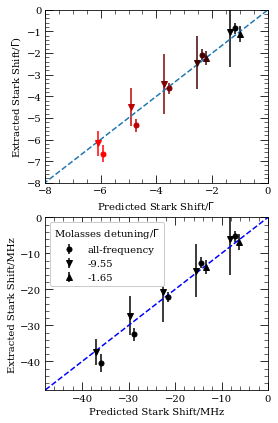

<Figure size 108x93.6 with 0 Axes>

In [20]:

from arc import Rubidium, DynamicPolarizability
from scipy.constants import c, epsilon_0
atom = Rubidium()
n_gnd = atom.groundStateN  # n=5
gnd_calc = DynamicPolarizability(atom, n_gnd, 0, 1/2)  # 5S_1/2 ground state
gnd_calc.defineBasis(atom.groundStateN, n_gnd + 4)

n_exc = atom.groundStateN
exc_calc = DynamicPolarizability(atom, n_exc, 1, 3/2)  # 5P_3/2 excited state
exc_calc.defineBasis(atom.groundStateN, n_exc + 5)

wavelength = 1560e-9
alpha0, alpha1, alpha2, alphaC, alphaP, closestState = exc_calc.getPolarizability(wavelength, units="SI")

def cicero_volt_to_power_out(voltage):
    return 6.6e-6 * 10 / 3.92 * voltage  # output power in W

power = cicero_volt_to_power_out(np.array(odt_att_list))
t2 = np.sqrt(100e-6)
w0 = 24e-6
E_field = (4 / w0) * (1 / t2) * np.sqrt(power / (np.pi * epsilon_0 * c)) 

shift = 1 / 4 * alpha0 * (E_field)**2 * 1e-6  # Stark shift in MHz
shift_fudged = 1 / 4 * alpha0 * (E_field)**2 * 1e-6 * 0.55  # Stark shift in MHz
# print(shift/gamma)
fig2 = plt.figure(figsize=(4.0, 7))
ax1 = fig2.add_subplot(2, 1,  1)
# dat_out_dict = {}
dat_out_array = np.empty((num_odt_att+1, 7), dtype=object)
dat_out_array[0,0] = "Stark_shift_predict_fudged/Gamma"
dat_out_array[0,1] = "Stark_shift_measured_all_frequency_analysis"
dat_out_array[0,2] = "Error_of_Stark_shift_measured_all_frequency_analysis"

dat_out_array[1:,0] = -shift_fudged/gamma
dat_out_array[1:,1] = stark_list
dat_out_array[1:,2] = sigma_stark_list


# ax2.plot(np.array(f0_list) * gamma, -shift, '.')
# dat_out_dict[f'Stark_shift_predict_fudged/Gamma']=\
# -shift_fudged/gamma
# dat_out_dict[f'Stark_shift_measured_all_frequency_analysis']=\
# stark_list
# dat_out_dict[f'Error_of_Stark_shift_measured_all_frequency_analysis']=\
# sigma_stark_list
for odt_att_num in range(num_odt_att):
    ax1.errorbar(-shift_fudged[odt_att_num]/gamma, stark_list[odt_att_num], \
             yerr = sigma_stark_list[odt_att_num], marker = '.', ls = 'none', color = (red_color[odt_att_num], 0, 0),ms = 10)

mol_freq_select = [1, 8]
markerlist = ['v','^']
dodgelist = [-1, 1]
for mol_freq_counter, mol_freq_num in enumerate(mol_freq_select):
    dat_out_array[0,2*(mol_freq_counter+1)+1] = f'Stark_shift_measured_single_frequency_analysis(mol_detuning = {mol_freq_list[mol_freq_num]/gamma:.2f}$\Gamma$)'
    dat_out_array[0,2*(mol_freq_counter+1)+2] = f'Error_of_Stark_shift_measured_single_frequency_analysis(mol_detuning = {mol_freq_list[mol_freq_num]/gamma:.2f}$\Gamma$)'
    
#     dat_out_dict[f'Stark_shift_measured_single_frequency_analysis(mol_detuning = {mol_freq_list[mol_freq_num]/gamma:.2f}$\Gamma$)']=\
#     stark_xarray[mol_freq_num].values
#     dat_out_dict[f'Error_of_Stark_shift_measured_single_frequency_analysis(mol_detuning = {mol_freq_list[mol_freq_num]/gamma:.2f}$\Gamma$)']=\
#     sigma_stark_xarray[mol_freq_num].values
    dat_out_array[1:,2*(mol_freq_counter+1)+1] = stark_xarray[mol_freq_num, :]
    dat_out_array[1:,2*(mol_freq_counter+1)+2] = sigma_stark_xarray[mol_freq_num, :]
    for odt_att_num in range(num_odt_att):
        ax1.errorbar((-shift_fudged[odt_att_num] + dodgelist[mol_freq_counter])/gamma, stark_xarray[mol_freq_num, odt_att_num], \
                 yerr = sigma_stark_xarray[mol_freq_num, odt_att_num], ls = 'none', marker = markerlist[mol_freq_counter],\
                 color = (red_color[odt_att_num], 0, 0))
ax1.plot(np.linspace(-60, 0, 100), np.linspace(-60, 0, 100), '--')
ax1.set_xlim(-8, 0)
ax1.set_ylim(-8, 0)
ax1.set_ylabel('Extracted Stark Shift/$\Gamma$)')
ax1.set_xlabel('Predicted Stark Shift/$\Gamma$')

ax2 = fig2.add_subplot(2, 1, 2)

ax2.errorbar(-shift_fudged, np.array(stark_list) * gamma, \
             yerr = np.array(sigma_stark_list) * gamma, marker = '.', ls = 'none', color = 'black',ms = 10, label = 'all-frequency')

for mol_freq_counter, mol_freq_num in enumerate(mol_freq_select):
    ax2.errorbar(-shift_fudged + dodgelist[mol_freq_counter], stark_xarray[mol_freq_num] * gamma, \
             yerr = sigma_stark_xarray[mol_freq_num] * gamma, ls = 'none', marker = markerlist[mol_freq_counter],\
             color = 'black', label = f'{mol_freq_list[mol_freq_num]/gamma:.2f}')
ax2.plot(np.linspace(-60, 0, 100), np.linspace(-60, 0, 100), '--',color='b')
ax2.set_xlim(-48, 0)
ax2.set_ylim(-48, 0)
ax2.set_ylabel(f'Extracted Stark Shift/MHz')
ax2.set_xlabel('Predicted Stark Shift/MHz')
ax2.legend(title='Molasses detuning/$\Gamma$', bbox_to_anchor=(0, 1), loc='upper left',fancybox=True, framealpha=1)
figlegend = pylab.figure(figsize = (1.5,1.3))

# produce a legend for the objects in the other figure
pylab.figlegend(*ax2.get_legend_handles_labels(), loc = 'upper left')
plt.show()  
save_dir = Path(fig_directory)
save_dir.mkdir(parents=True, exist_ok=True)
file_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- single vs all.png'
file_path = Path(save_dir, file_name)
fig2.savefig(file_path, dpi=500,bbox_inches='tight', pad_inches = 0.5)
legend_name = f'figure -- pzt_num - {pzt_num} -- tweezer_num - {tweezer_num} -- single vs all -- legend.png'
legend_path = Path(save_dir, legend_name)
figlegend.savefig(legend_path, dpi=300)
plt.close(fig2)


save_data_dir = Path(fig_data_directory)
file_name = 'figure-2b_data(inset).txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in dat_out_array:
        csv_writer.writerow(row)
        
# save_data_dir = Path(fig_data_directory)
# file_name = 'figure - 2b(inset).txt'
# dat_file_path = Path(save_data_dir, file_name)
# with open(dat_file_path, 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file, delimiter=',')
#     csv_writer0 = csv.writer(csv_file, delimiter=' ')
#     for key in dat_out_dict:
#         csv_writer0.writerow(key)
#         csv_writer.writerow(dat_out_dict[key])
#         csv_writer0.writerow('\r\n')

c:\python37-32\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


tweezer_num=0


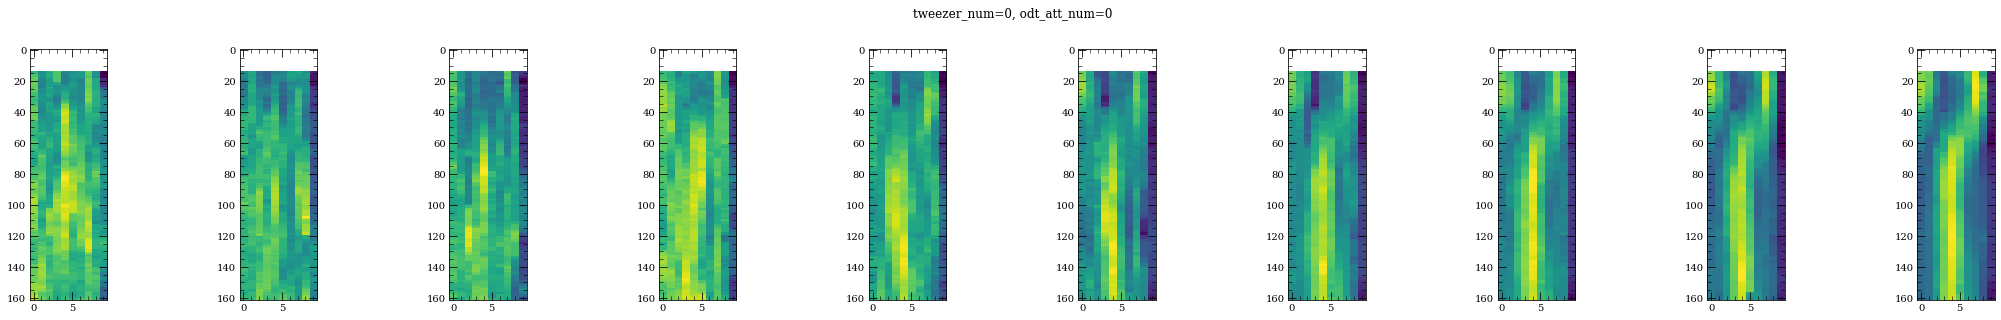

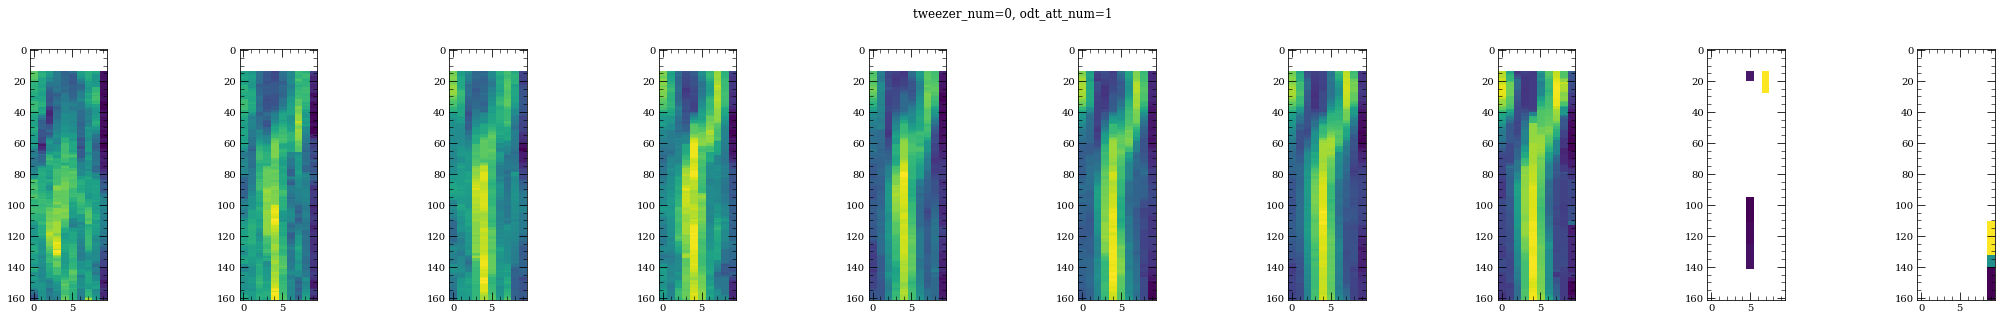

C:\Users\Microscope\AppData\Roaming\Python\Python37\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\Microscope\AppData\Roaming\Python\Python37\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\Microscope\AppData\Roaming\Python\Python37\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Microscope\AppData\Roaming\Python\Python37\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
c:\python37-32\lib\site-packages\numpy\ma\core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


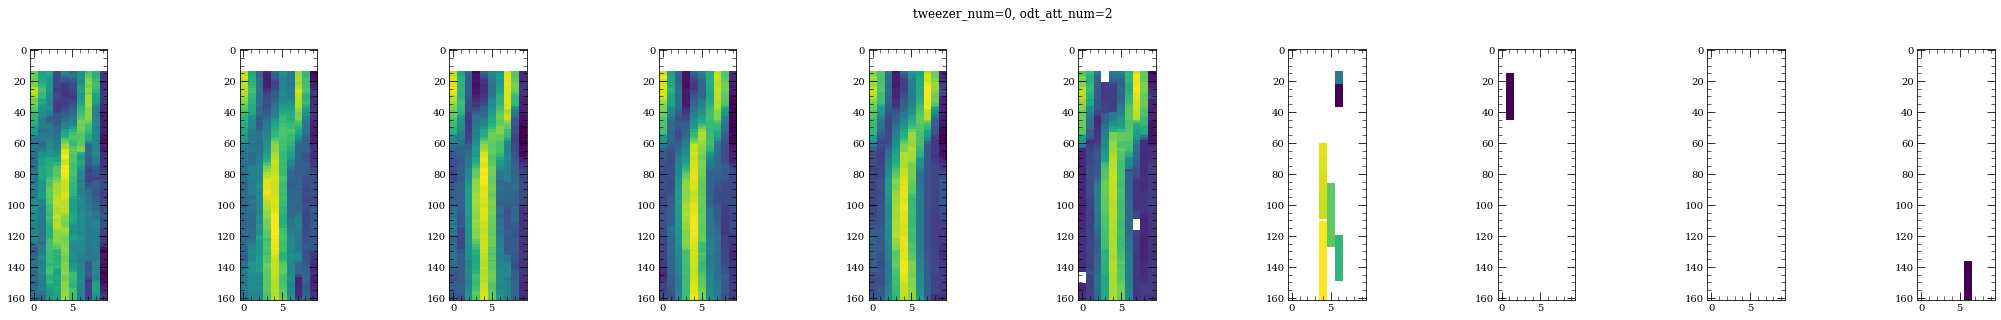

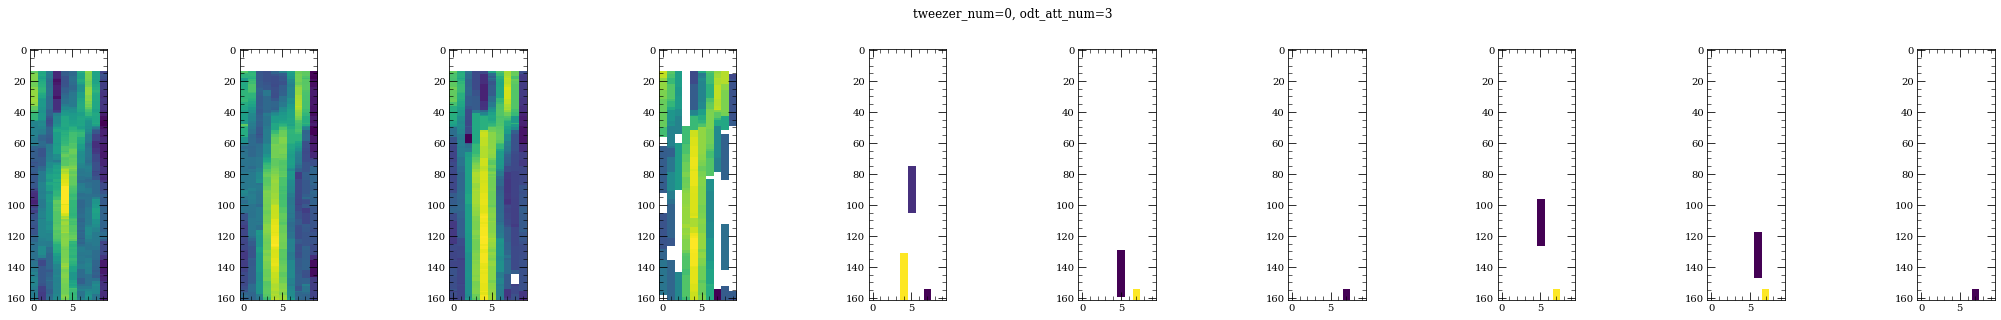

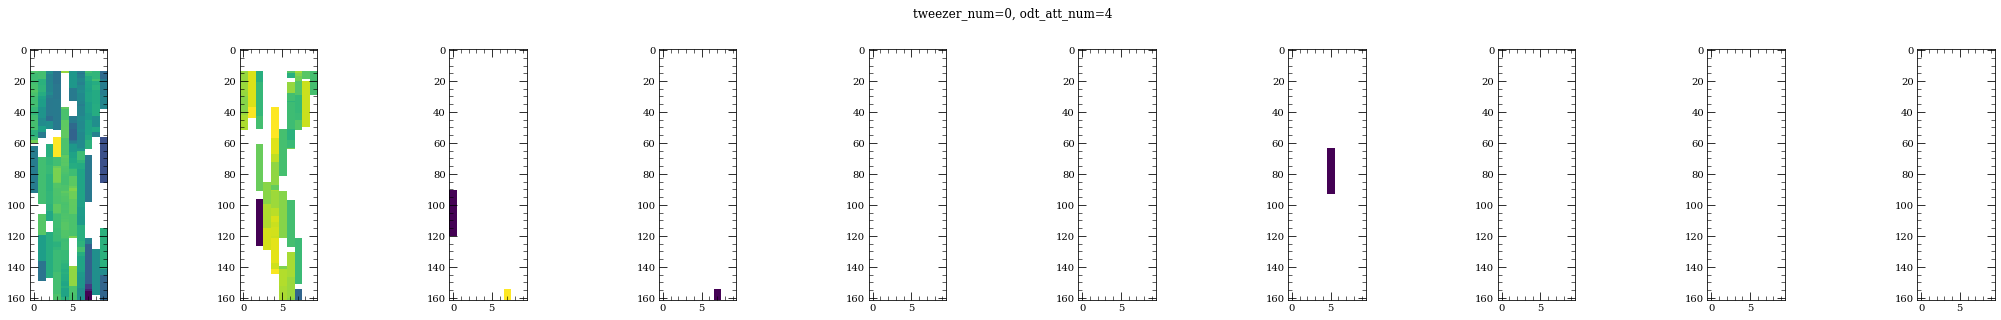

tweezer_num=1


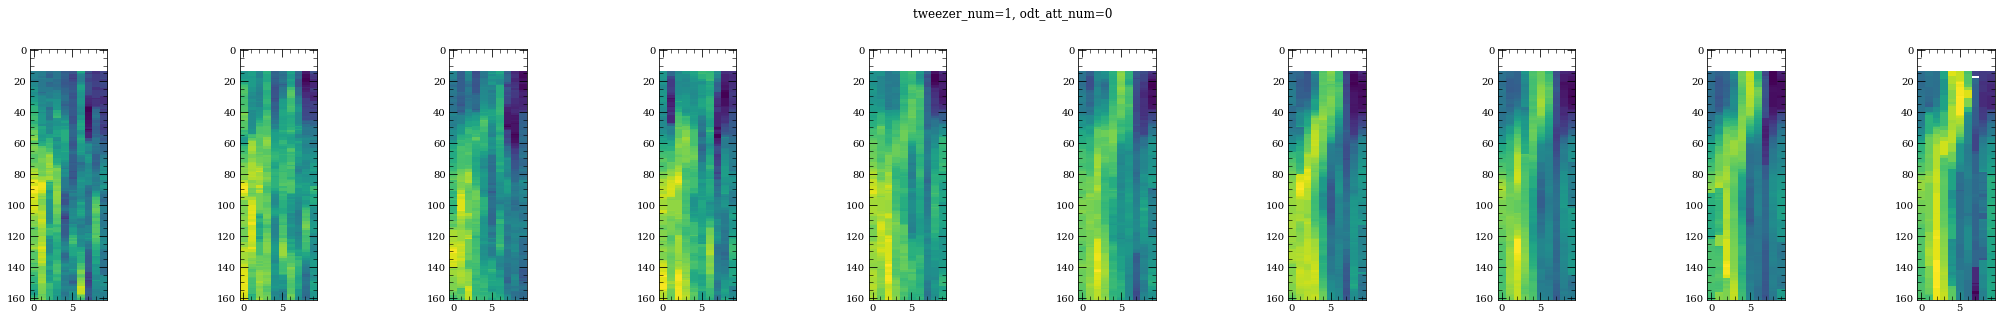

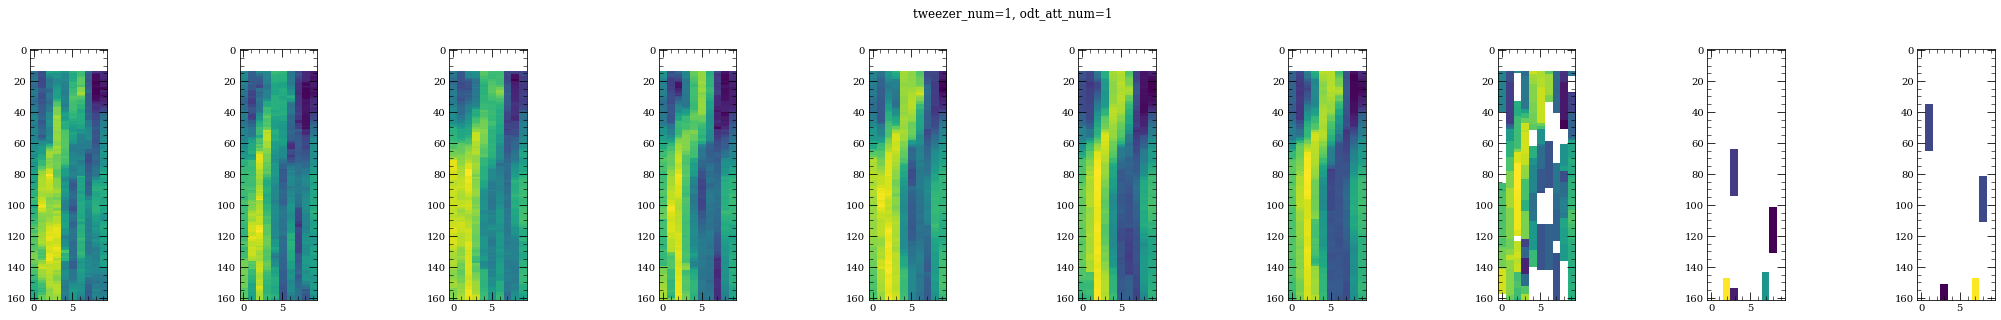

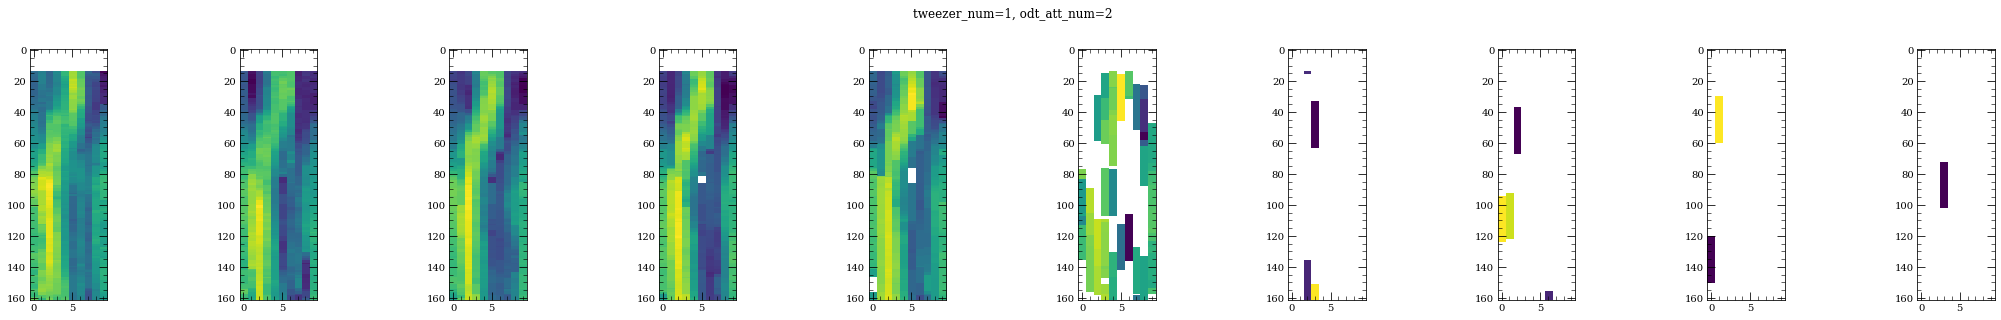

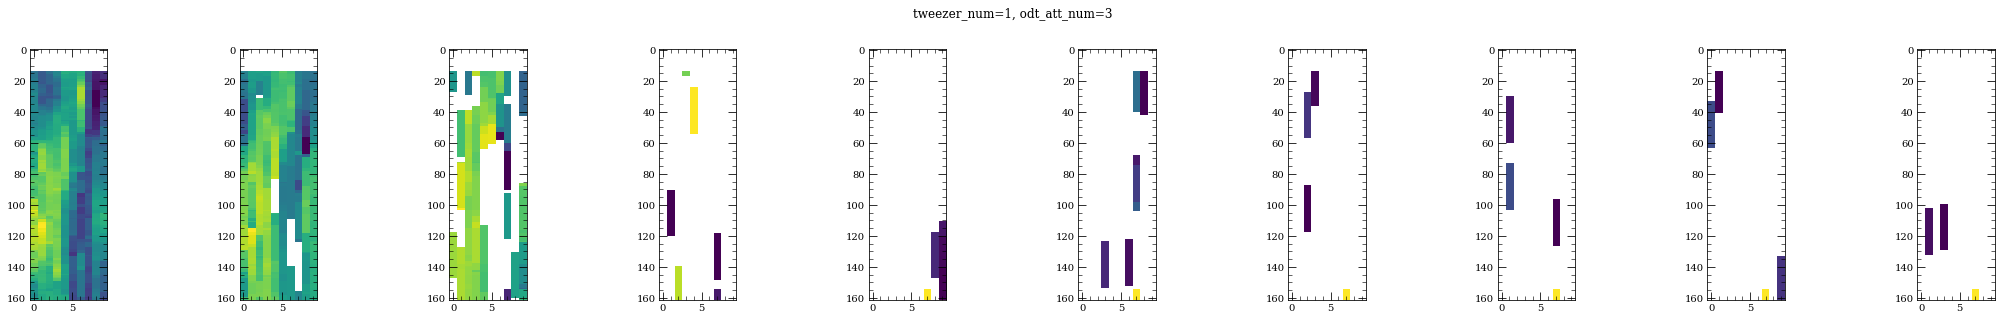

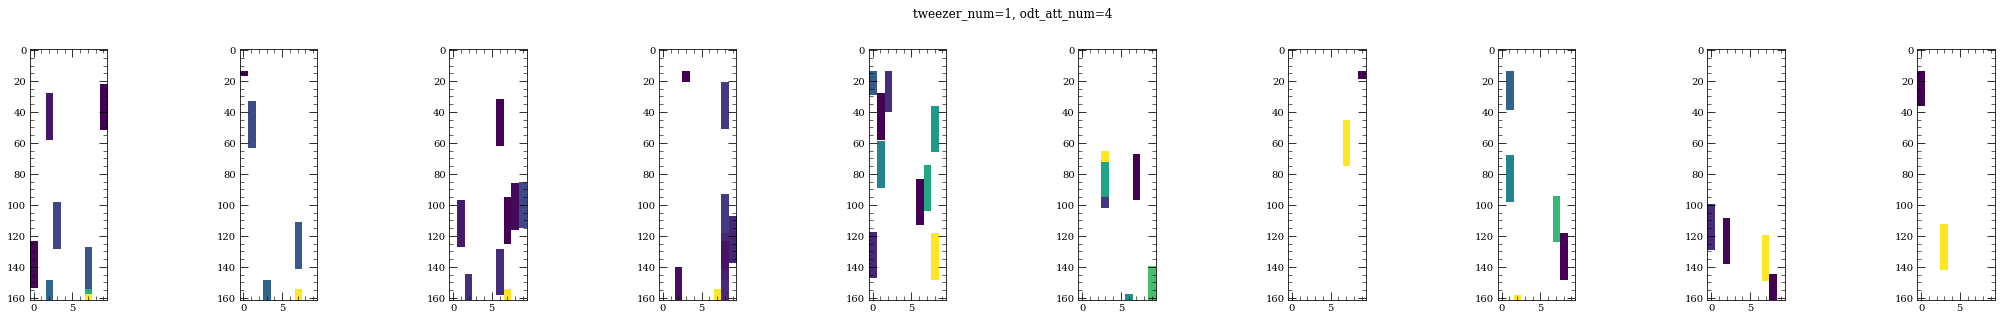

tweezer_num=2


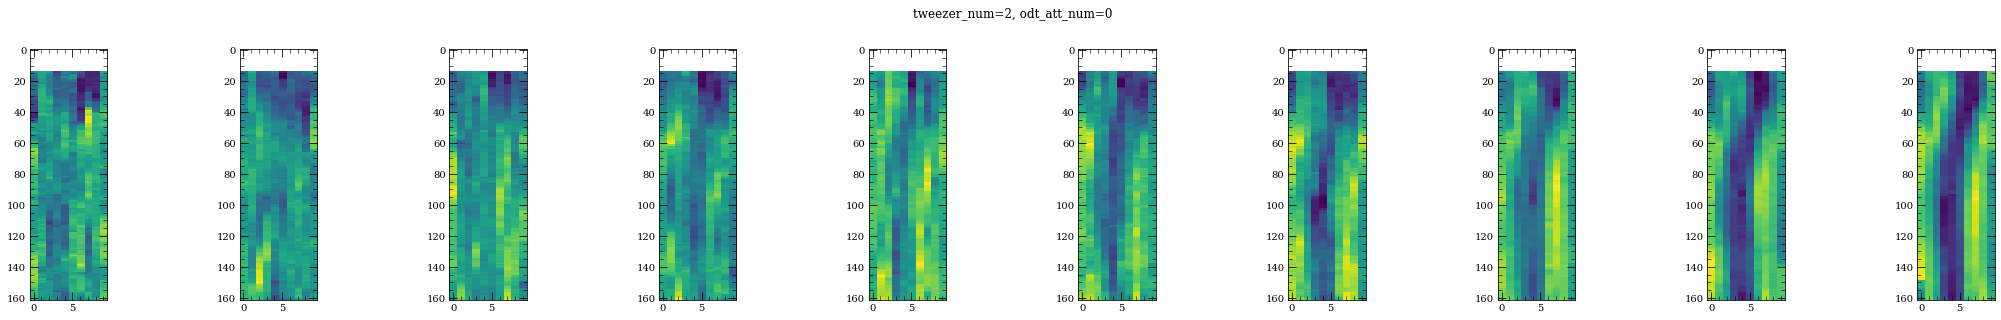

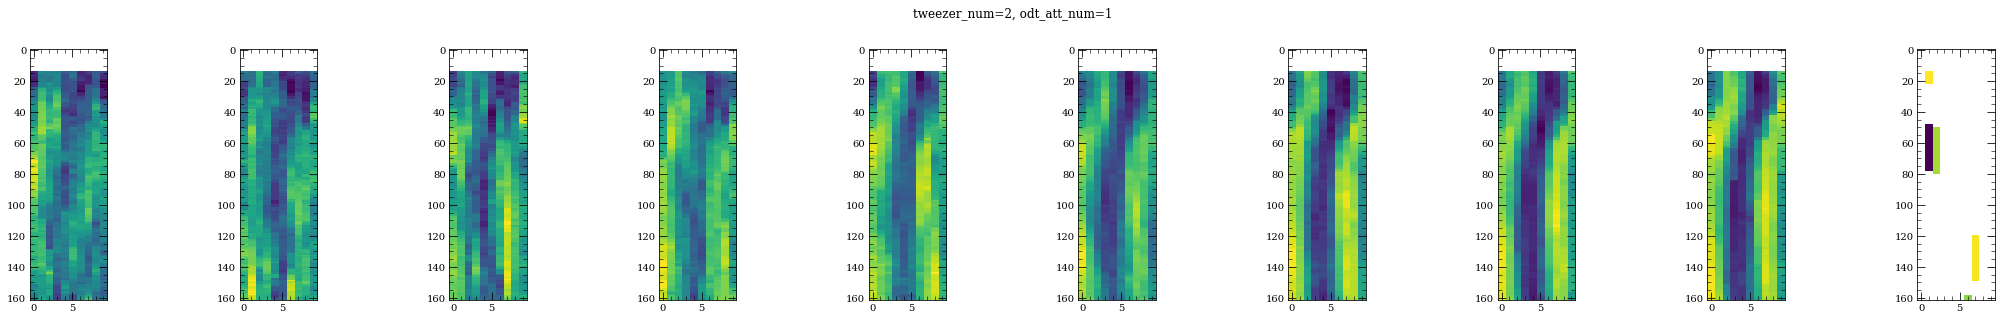

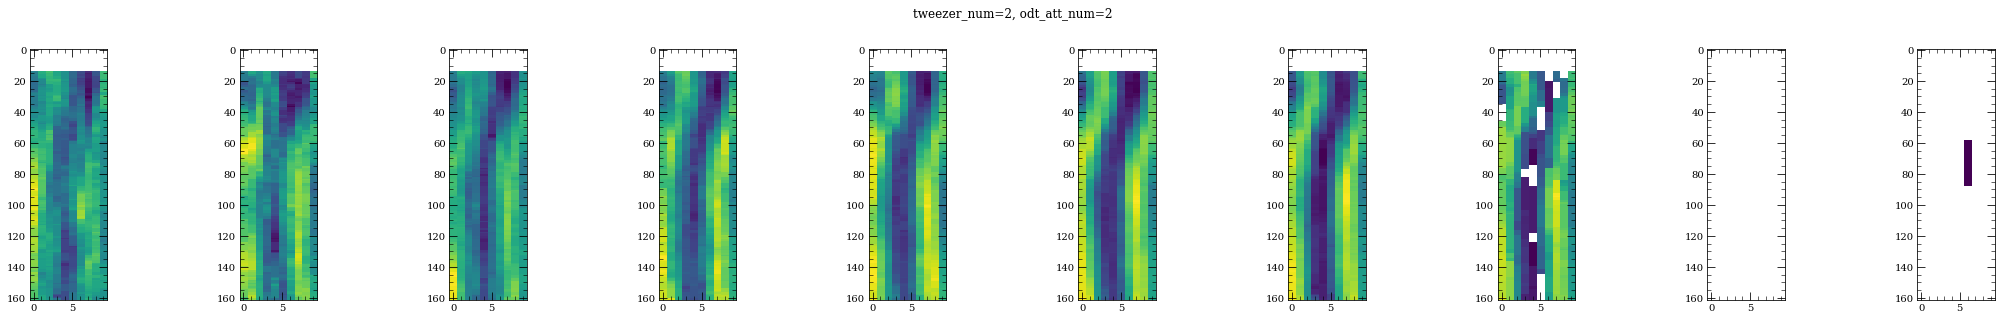

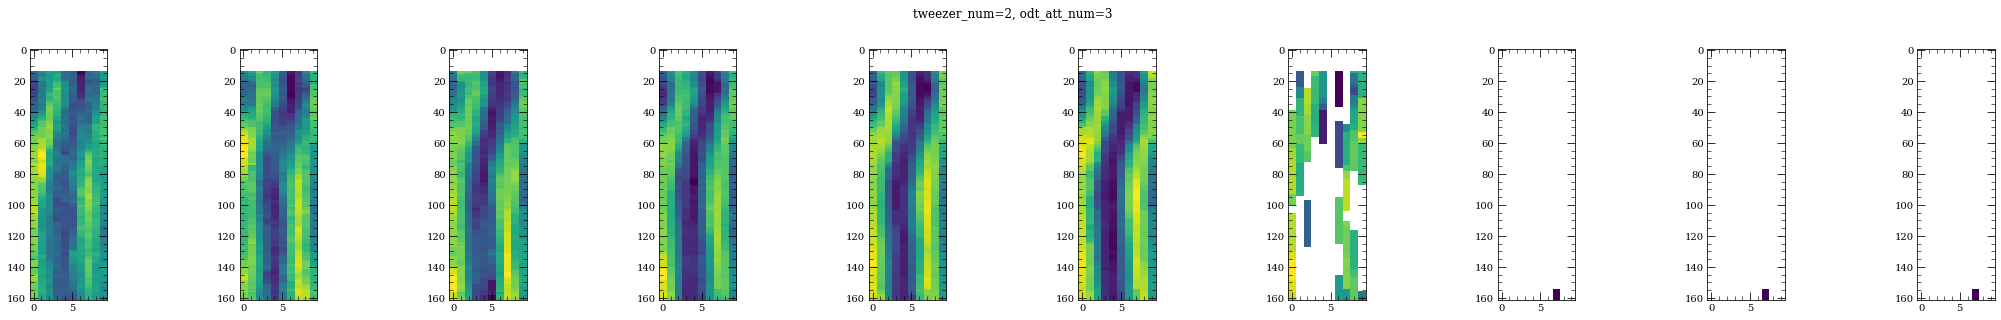

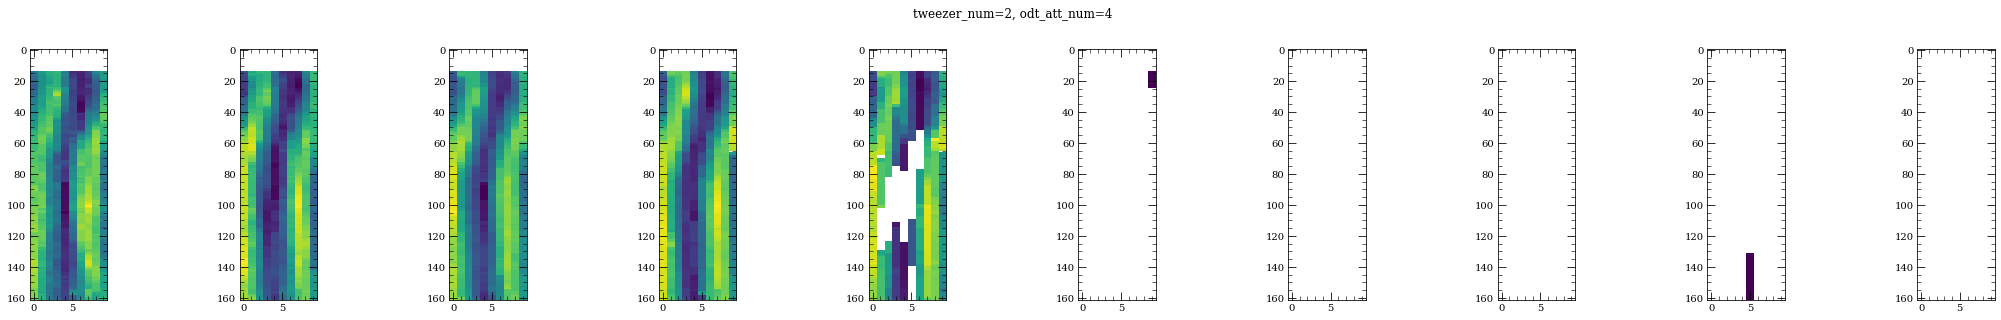

tweezer_num=3


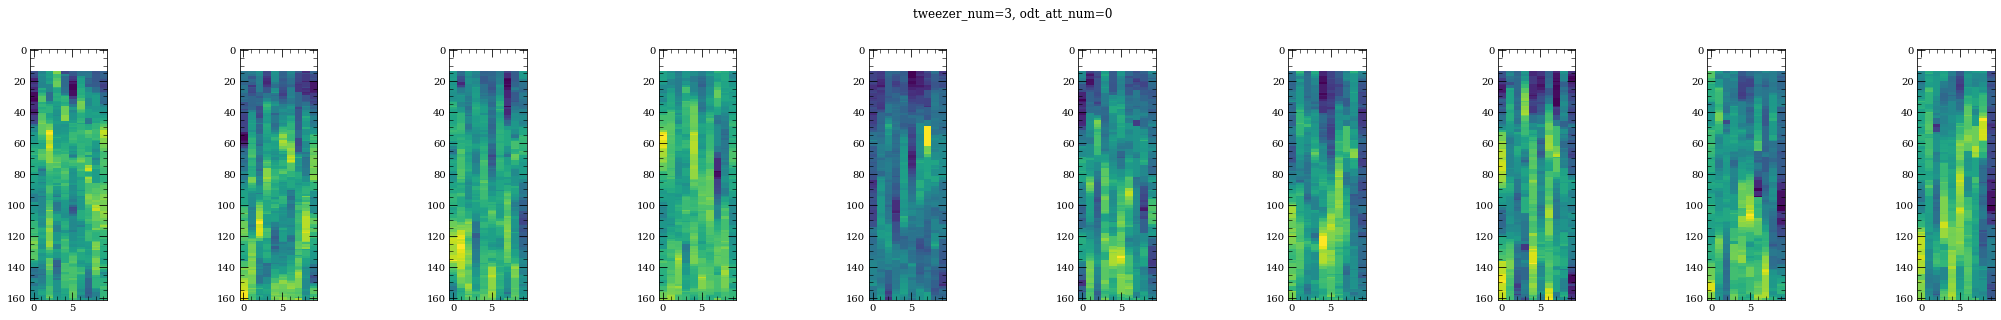

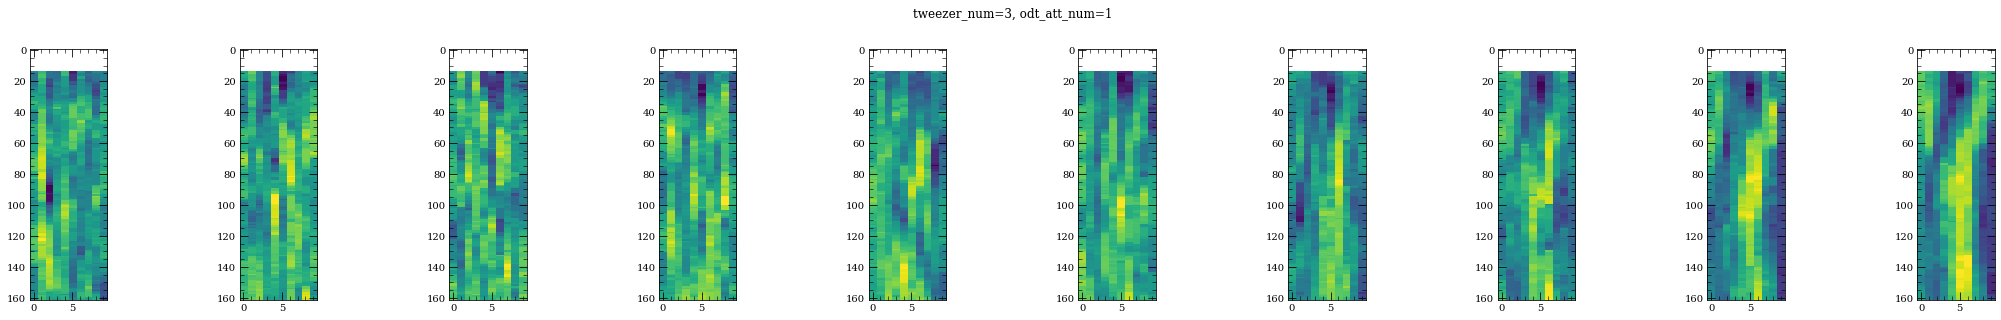

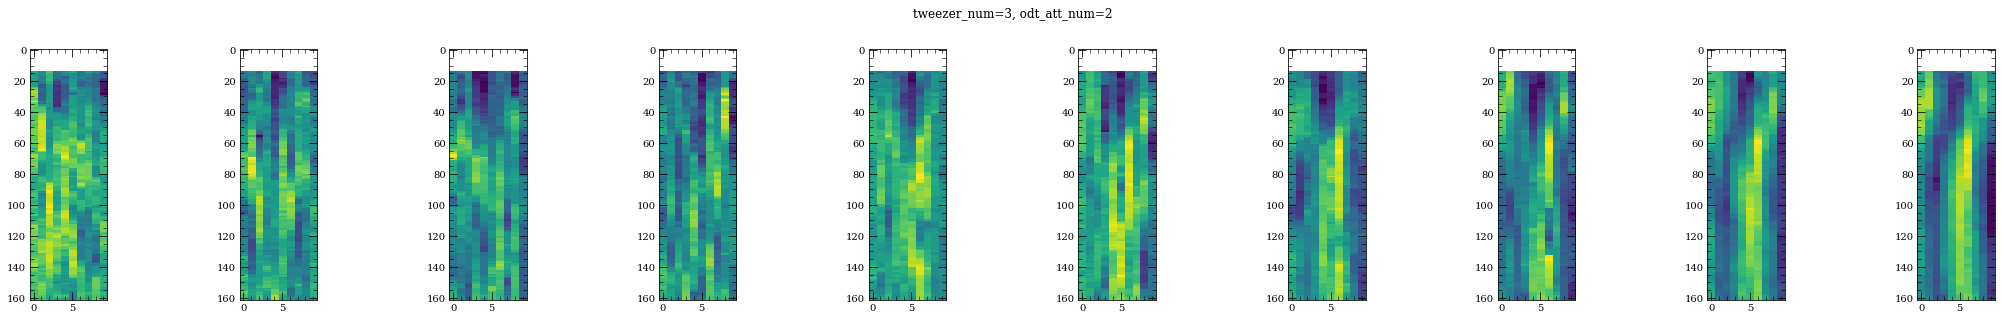

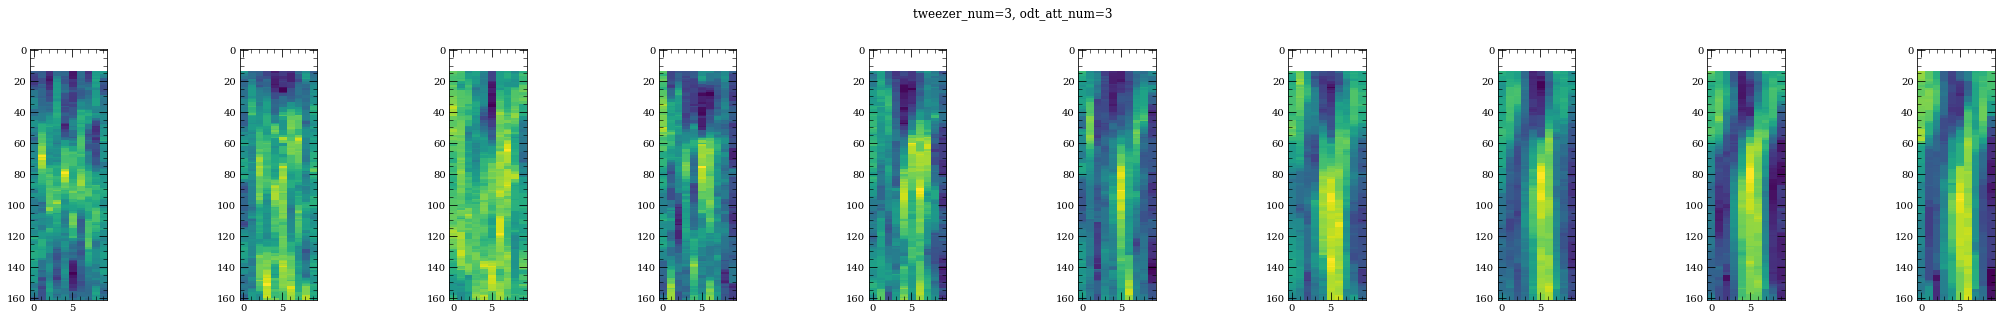

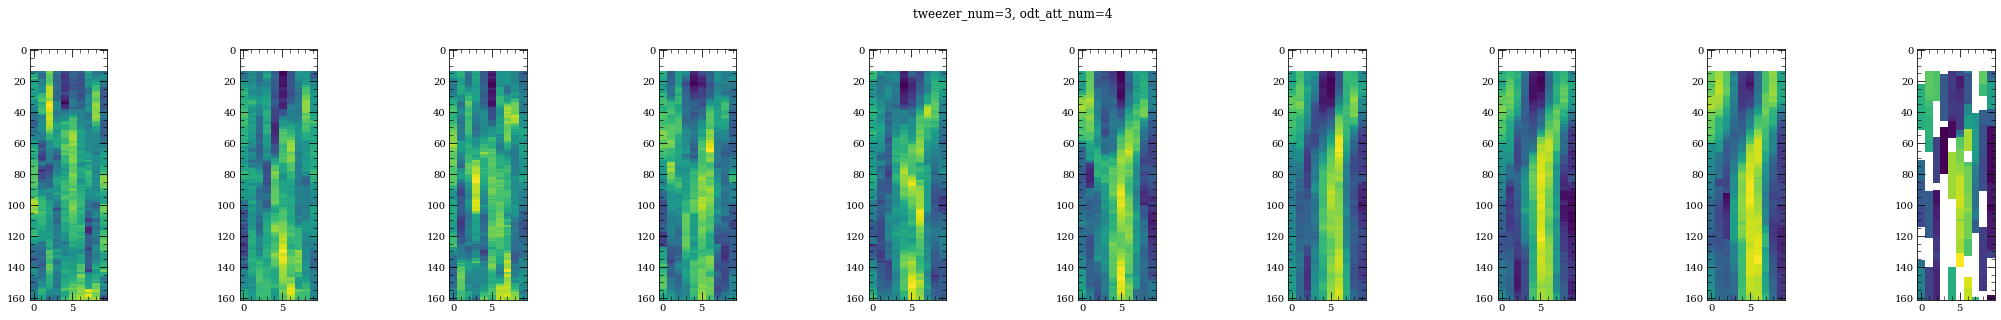

tweezer_num=4


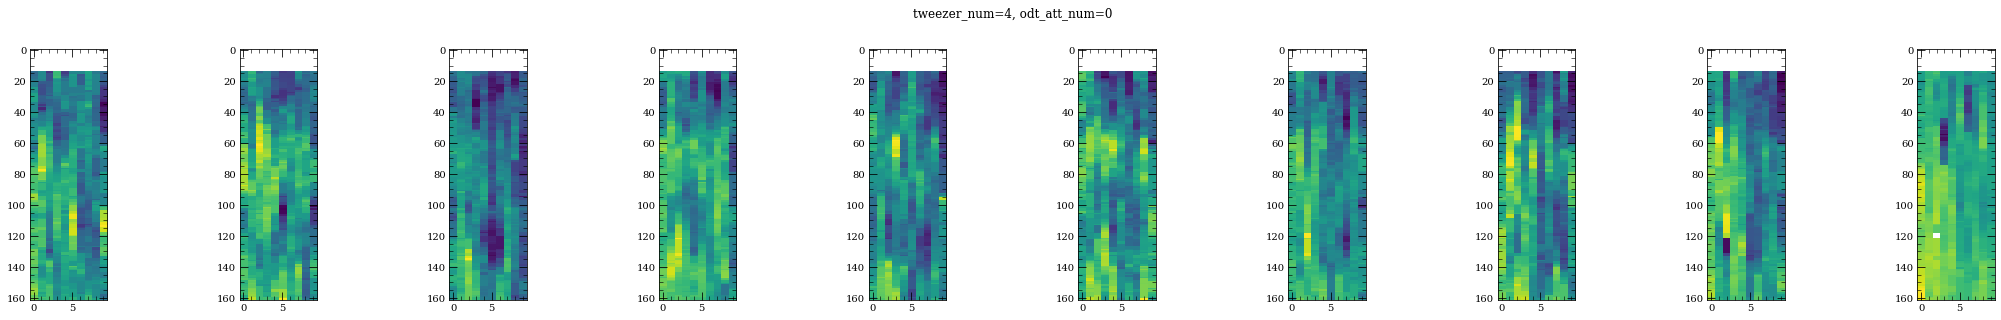

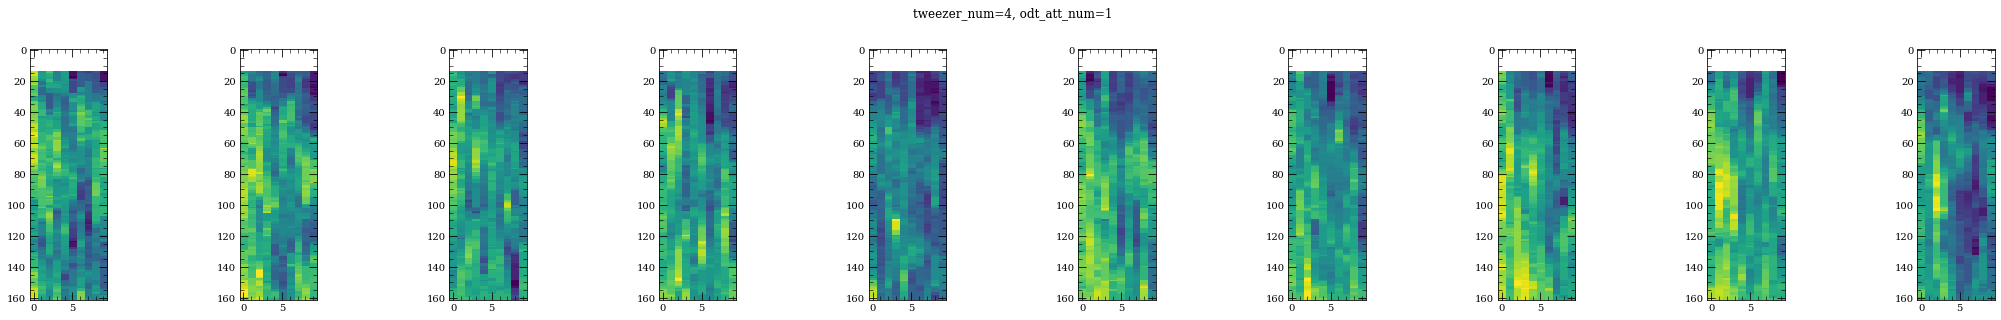

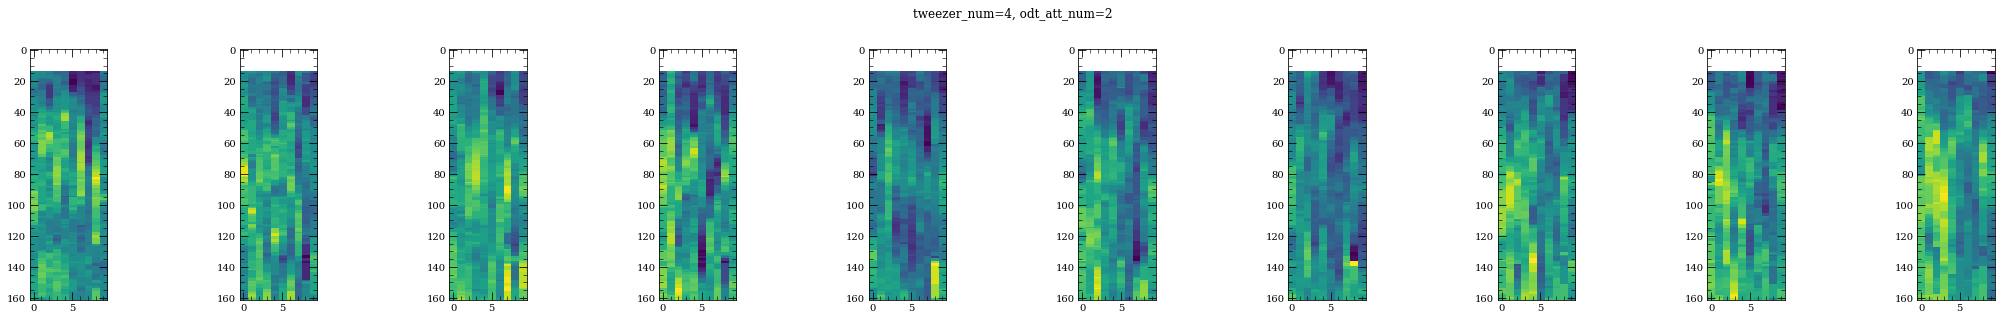

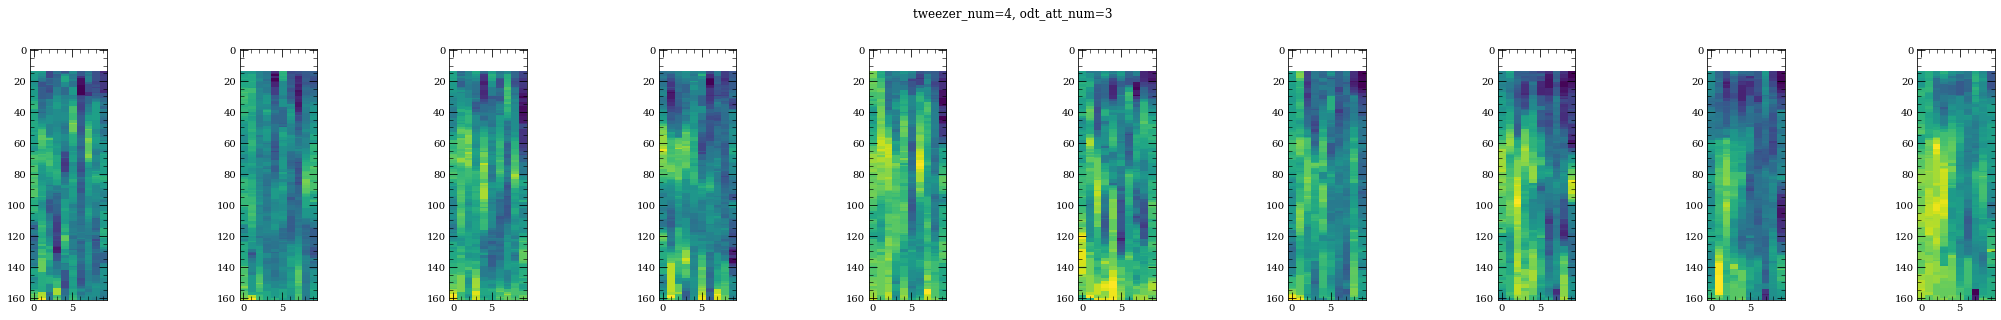

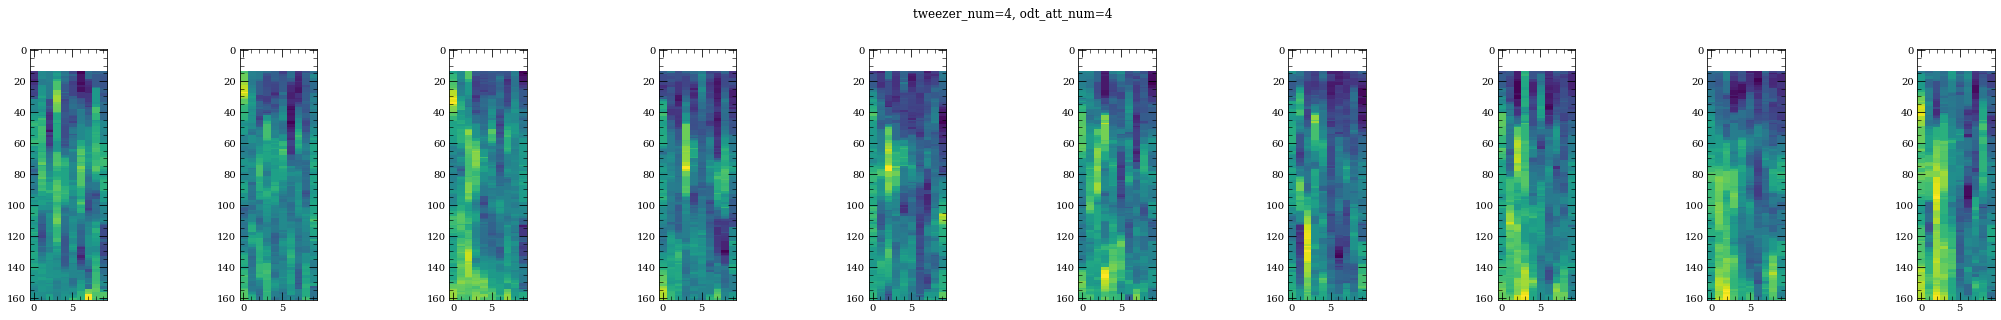

In [21]:
rolling_size = 30
brightness_rolling = xr.DataArray(coords=coords_list).isel(loop=slice(0, -rolling_size//2))
sigma_brightness_rolling = xr.DataArray(coords=coords_list).isel(loop=slice(0, -rolling_size//2))
for loop in range(rolling_size//2, num_loops-rolling_size//2):
    brightness_rolling[loop, :, :, :, :] = np.nanmean(brightness_xr[loop-rolling_size//2:loop+rolling_size//2, :, :, :, :], 0)
    sigma_brightness_rolling[loop, :, :, :, :] = np.nanstd(brightness_xr[loop-rolling_size//2:loop+rolling_size//2, :, :, :, :], 0)

for tweezer_num in range(num_tweezer):
    print(f'tweezer_num={tweezer_num}')
    for odt_att_num in range(num_odt_att):
        fig = plt.figure(figsize=(num_mol_freq*3, 4))
        fig.suptitle(f'tweezer_num={tweezer_num}, odt_att_num={odt_att_num}', y=1.1)
        for mol_freq_num in range(num_mol_freq):
#             print(mol_freq_num)
            ax = fig.add_subplot(1, num_mol_freq, mol_freq_num + 1)
            ax.imshow(brightness_rolling.isel(mol_freq=mol_freq_num, 
                                              tweezer=tweezer_num, odt_att=odt_att_num), aspect=0.2)
        fig.set_tight_layout(True)
    plt.show()

In [22]:
from scipy.optimize import curve_fit

phase_finding_dict = {0: (4, 2),
                      1: (5, 1),
                      2: (5, 2),
                      3: (7, 4)}

phase_coords_list = [('loop', range(num_loops-rolling_size//2)),
                     ('tweezer', tweezer_list),
                     ('pzt', pzt_list)]
phase_xr = xr.DataArray(coords=phase_coords_list)
k_xr = xr.DataArray(coords=phase_coords_list)


pzt_vals = phase_xr.coords['pzt'] - 5.5

def cos_fit_func(x, k, phase_offset, amplitude, offset):
    return amplitude * np.cos(k * x + phase_offset) + offset

for tweezer_num in [0, 1, 2, 3]:
    for loop_num in range(rolling_size//2, num_loops-rolling_size//2):
        if loop_num % 10 ==0:
            print(loop_num)
        mol_freq_num, odt_att_num = phase_finding_dict[tweezer_num]
        brightness_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                       tweezer=tweezer_num, odt_att=odt_att_num)
#         fit_dict = e6_fit(input_data=pzt_vals, output_data=brightness_data, fit_func=cos_fit_func,
#                           param_guess=[1.84, 0, 10000, 2200], 
#                           param_keys=['k', 'phase_offset', 'amplitude', 'offset'],
#                           method='lm', xtol=0, gtol=0, ftol=1e-9)
        
        popt, pcov = curve_fit(cos_fit_func, pzt_vals, brightness_data, p0=[1.84, 0, 10000, 2200])
        
        
#         k = fit_dict['k']['val']
#         phase_offset = fit_dict['phase_offset']['val'] % (2 * np.pi)
        k = popt[0]
        phase_offset = popt[1]
        amp = popt[2]
        if amp < 0:
            phase_offset += np.pi
        phase_offset = phase_offset % (2 * np.pi)

        pzt_phase_vals = k * pzt_vals + phase_offset
        phase_xr[loop_num, tweezer_num, :] = pzt_phase_vals
        k_xr[loop_num, tweezer_num, :] = k
        
#         print(f'k={k}')
#         print(f'phase_offset={phase_offset}')
#         print(f'amp={amp}')
#         plt.figure()
#         plt.plot(pzt_vals, brightness_data, linestyle='none', marker='.', markersize=10, color='black')
#         pzt_model = np.linspace(0, 5.5, 100)
# #         model_data = cos_fit_func(pzt_model, **fit_dict['kwargs'])
#         model_data = cos_fit_func(pzt_model, *popt)
#         plt.plot(pzt_model, model_data, color='red')
#         plt.show()


20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


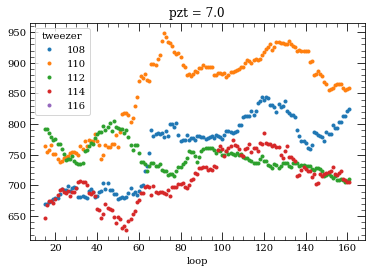

In [23]:
(200 * 2*np.pi/k_xr).isel(pzt=3).plot.line(x='loop', linestyle='none', marker='.')
plt.show()

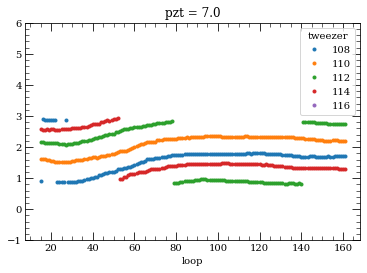

In [24]:
(phase_xr/(np.pi)).isel(pzt=3).plot.line(x='loop', linestyle='none', marker='.')
plt.ylim(-1, 6)
plt.show()
# (phase_xr/(2*np.pi)).isel(pzt=8).plot.line(x='loop', linestyle='none', marker='.')
# plt.ylim(-1, 3)
# plt.show()

tweezer_num=0, mol_freq_num=0


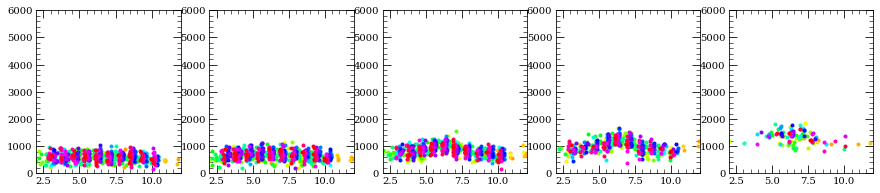

tweezer_num=0, mol_freq_num=1


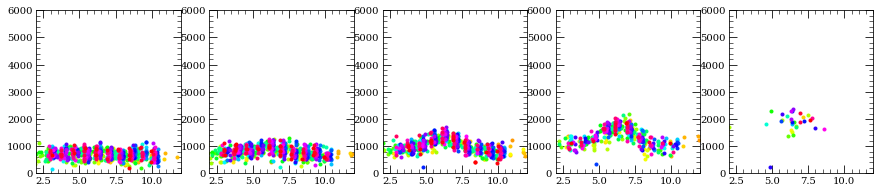

tweezer_num=0, mol_freq_num=2


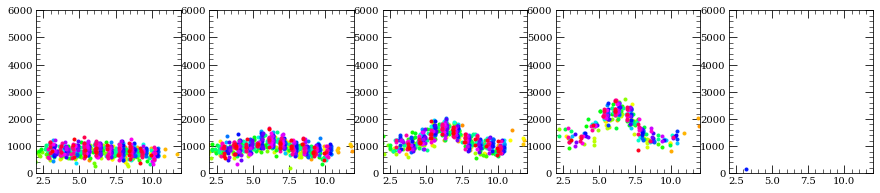

tweezer_num=0, mol_freq_num=3


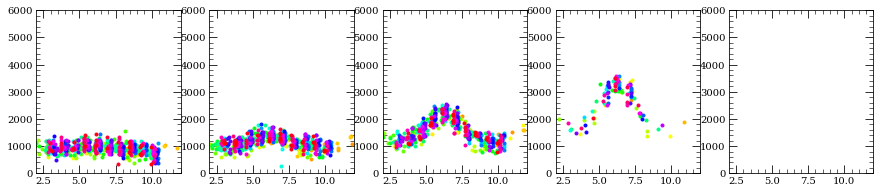

tweezer_num=0, mol_freq_num=4


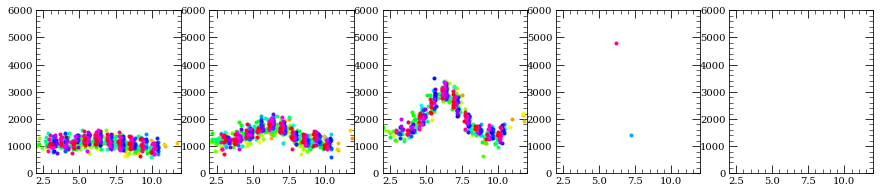

tweezer_num=0, mol_freq_num=5


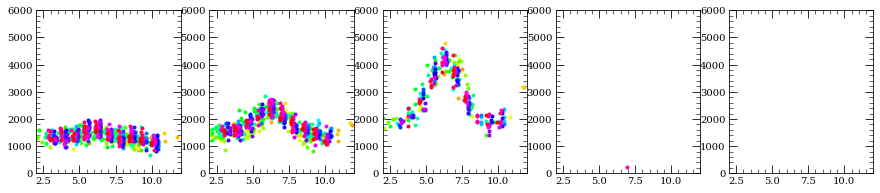

tweezer_num=0, mol_freq_num=6


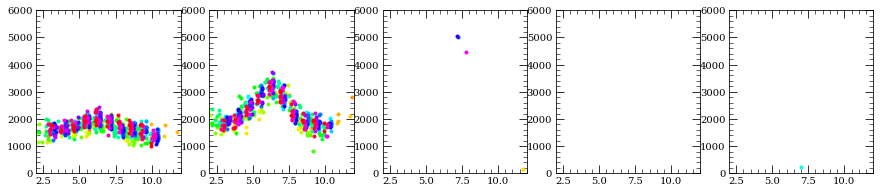

tweezer_num=0, mol_freq_num=7


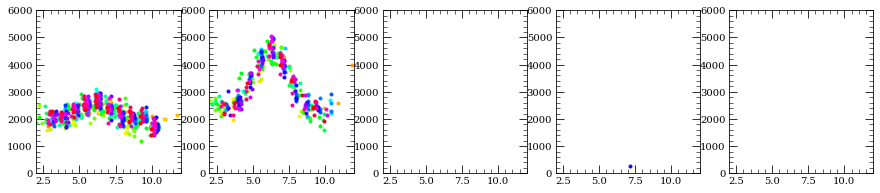

tweezer_num=0, mol_freq_num=8


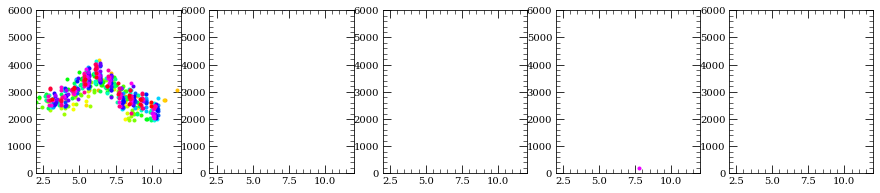

tweezer_num=0, mol_freq_num=9


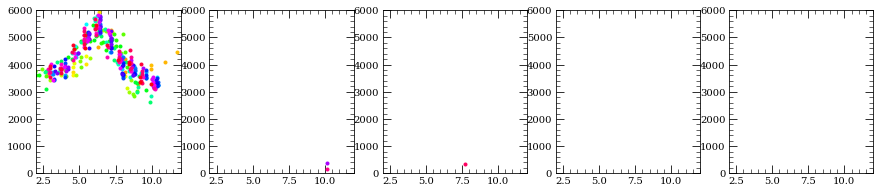

tweezer_num=1, mol_freq_num=0


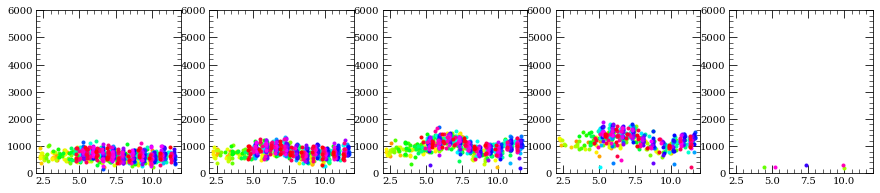

tweezer_num=1, mol_freq_num=1


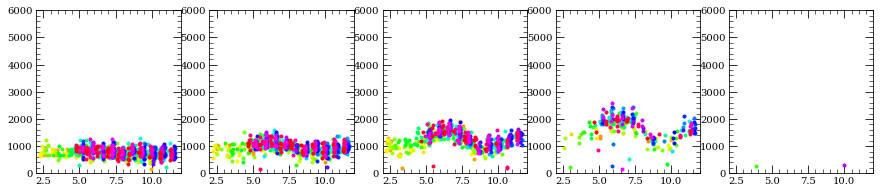

tweezer_num=1, mol_freq_num=2


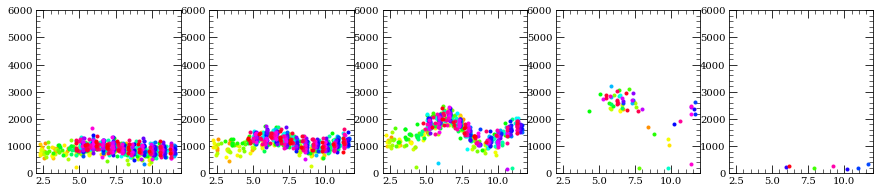

tweezer_num=1, mol_freq_num=3


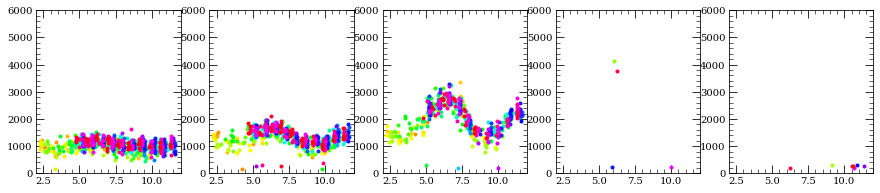

tweezer_num=1, mol_freq_num=4


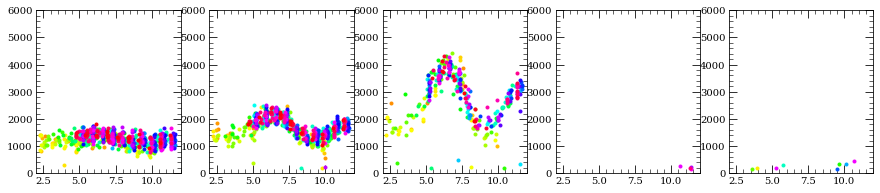

tweezer_num=1, mol_freq_num=5


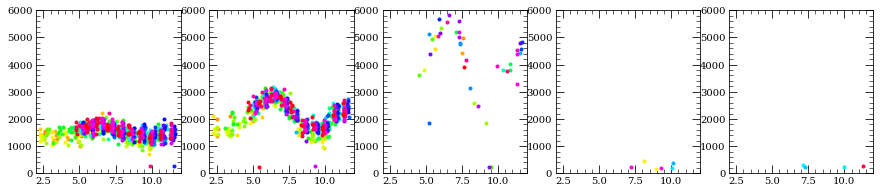

tweezer_num=1, mol_freq_num=6


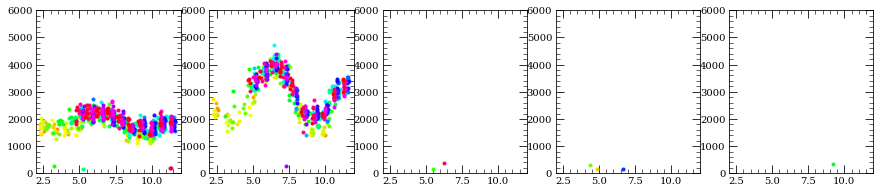

tweezer_num=1, mol_freq_num=7


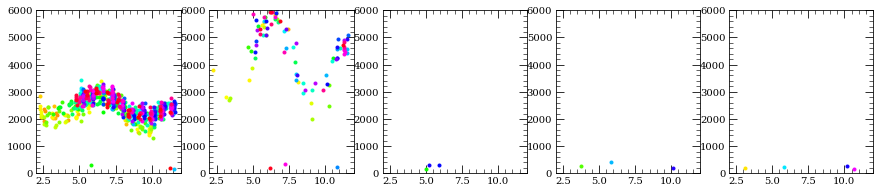

tweezer_num=1, mol_freq_num=8


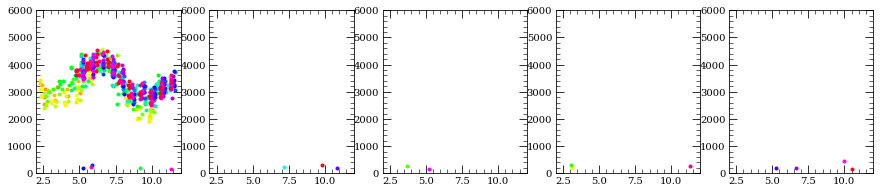

tweezer_num=1, mol_freq_num=9


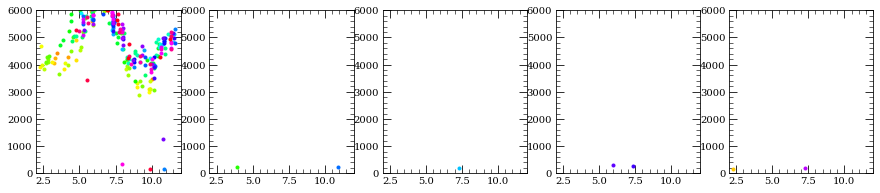

tweezer_num=2, mol_freq_num=0


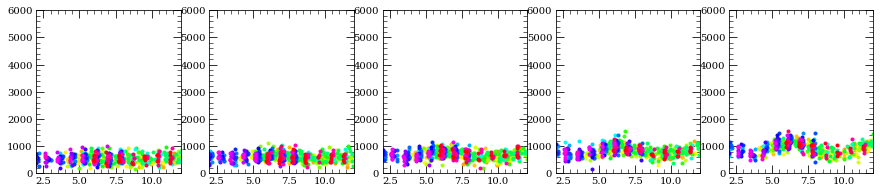

tweezer_num=2, mol_freq_num=1


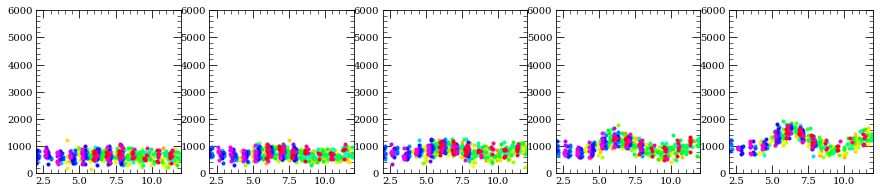

tweezer_num=2, mol_freq_num=2


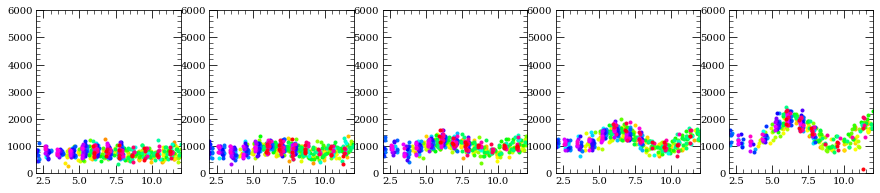

tweezer_num=2, mol_freq_num=3


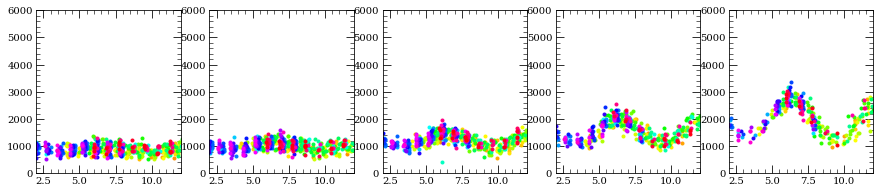

tweezer_num=2, mol_freq_num=4


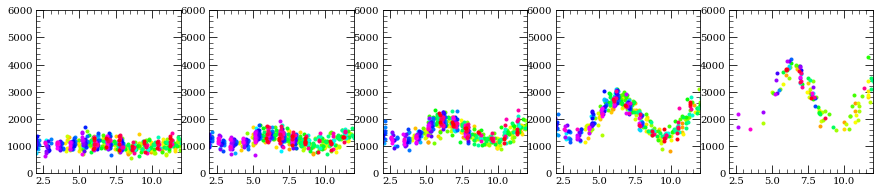

tweezer_num=2, mol_freq_num=5


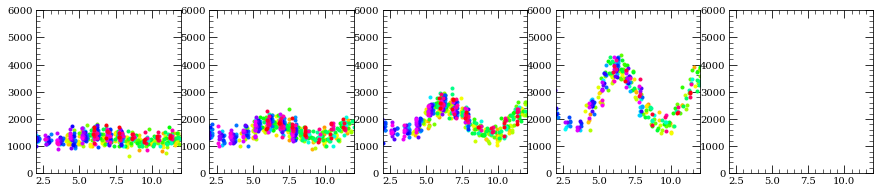

tweezer_num=2, mol_freq_num=6


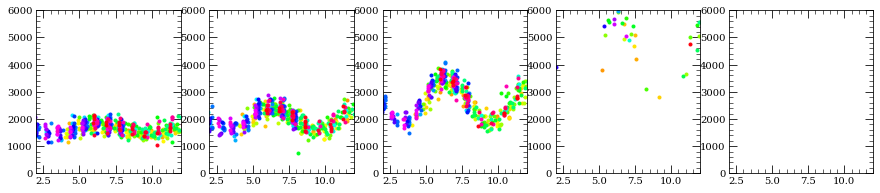

tweezer_num=2, mol_freq_num=7


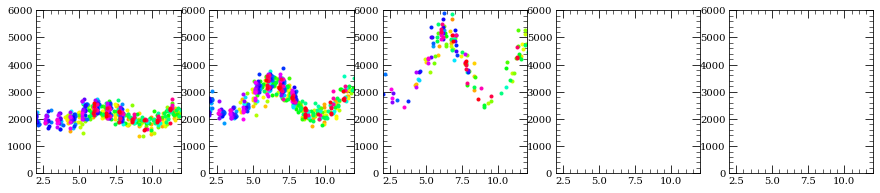

tweezer_num=2, mol_freq_num=8


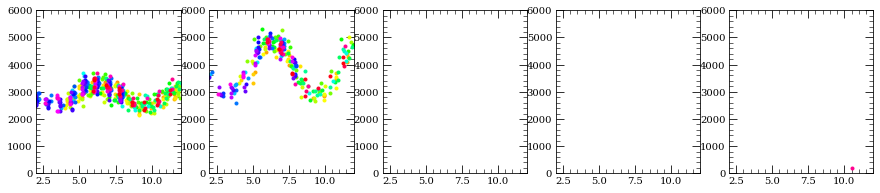

tweezer_num=2, mol_freq_num=9


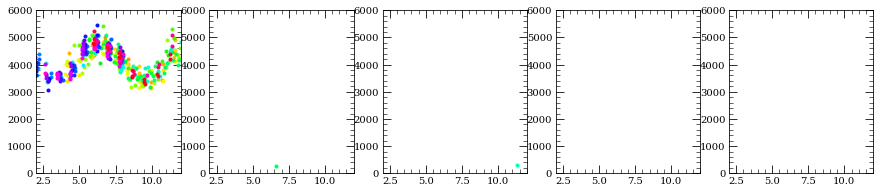

tweezer_num=3, mol_freq_num=0


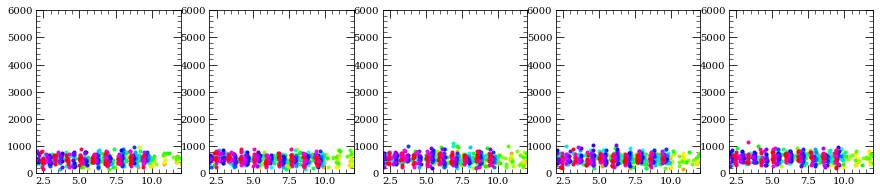

tweezer_num=3, mol_freq_num=1


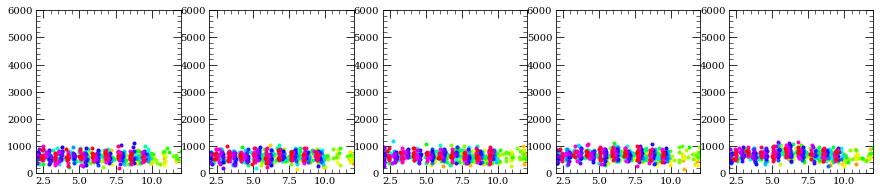

tweezer_num=3, mol_freq_num=2


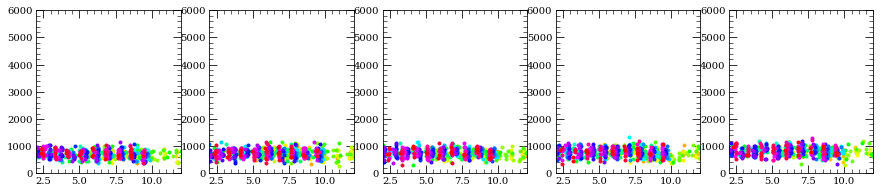

tweezer_num=3, mol_freq_num=3


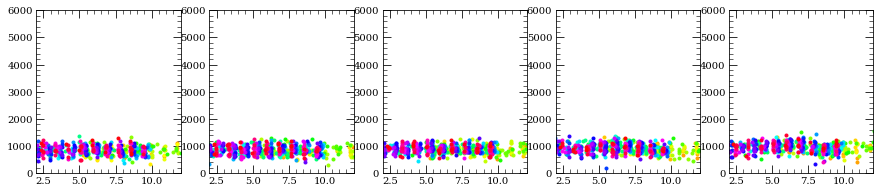

tweezer_num=3, mol_freq_num=4


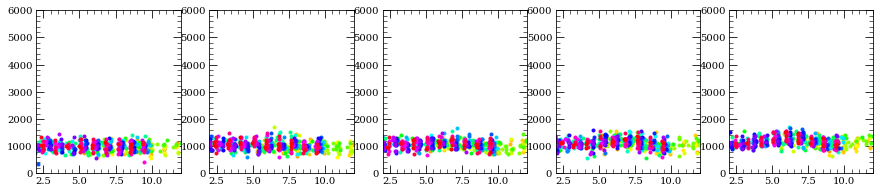

tweezer_num=3, mol_freq_num=5


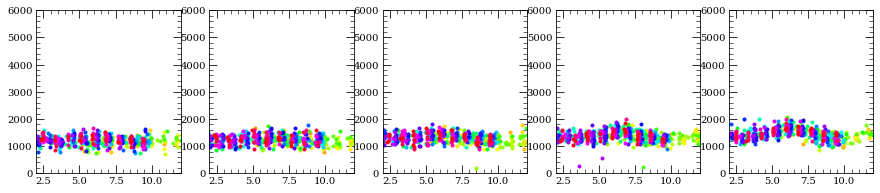

tweezer_num=3, mol_freq_num=6


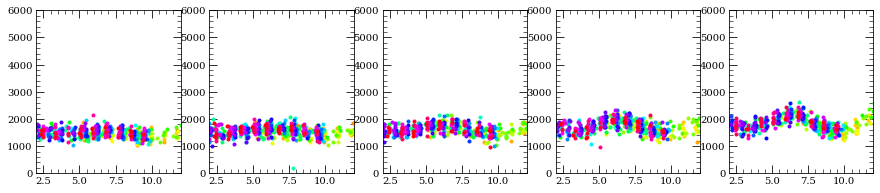

tweezer_num=3, mol_freq_num=7


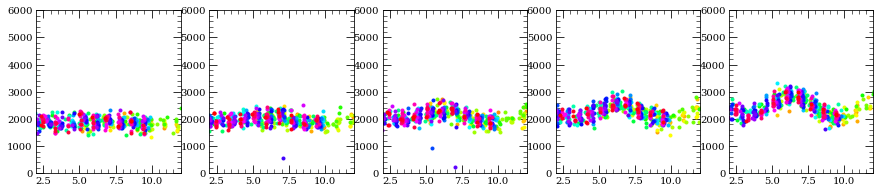

tweezer_num=3, mol_freq_num=8


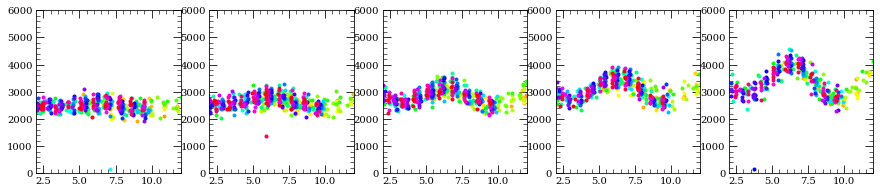

tweezer_num=3, mol_freq_num=9


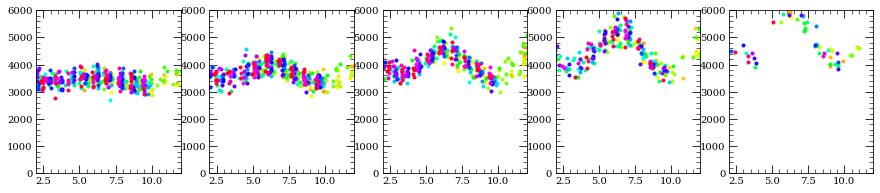

In [25]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size//2)

for tweezer_num in [0, 1, 2, 3]:
    for mol_freq_num in range(num_mol_freq):
        fig = plt.figure(figsize=(num_odt_att * 3, 3))
        print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
        for odt_att_num in range(num_odt_att):
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
            ax = fig.add_subplot(1, num_odt_att, odt_att_num + 1)
            for loop_num in range(rolling_size//2, num_loops-rolling_size//2):
                bright_data = brightness_xr.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num)
#                 pzt_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
#                                                       tweezer=tweezer_num, odt_att=odt_att_num).coords['pzt']
                pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
                color = hsv_to_rgb((hue_list[loop_num], 1, 1))
                ax.plot(pzt_data, bright_data, '.', color=color)
                ax.set_ylim(0, 6000)
                ax.set_xlim(2, 12)
        plt.show()

tweezer_num=0, mol_freq_num=0


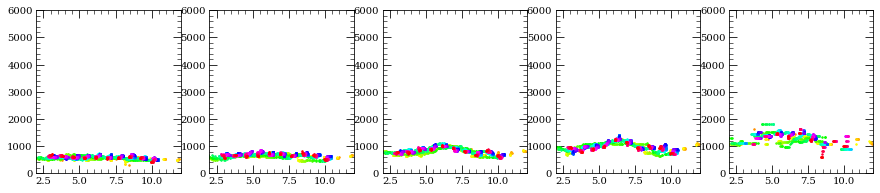

tweezer_num=0, mol_freq_num=1


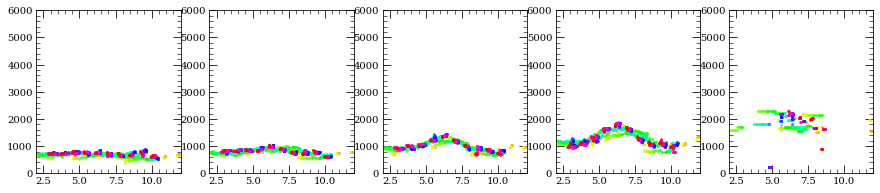

tweezer_num=0, mol_freq_num=2


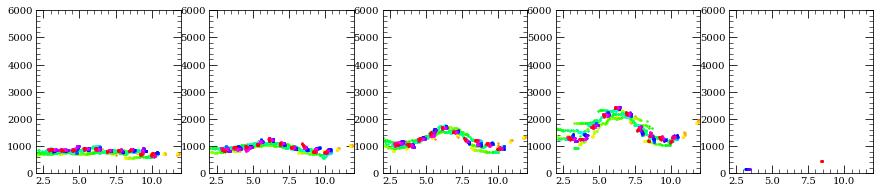

tweezer_num=0, mol_freq_num=3


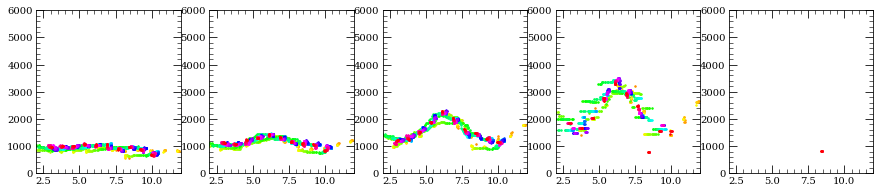

tweezer_num=0, mol_freq_num=4


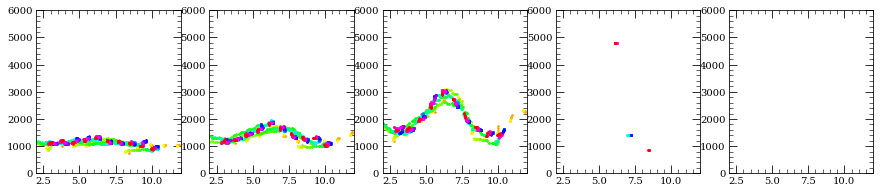

tweezer_num=0, mol_freq_num=5


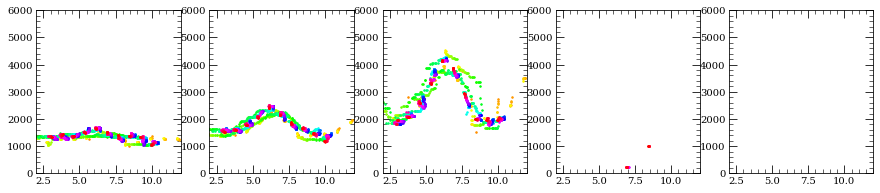

tweezer_num=0, mol_freq_num=6


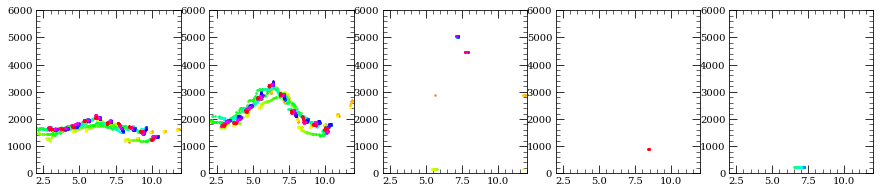

tweezer_num=0, mol_freq_num=7


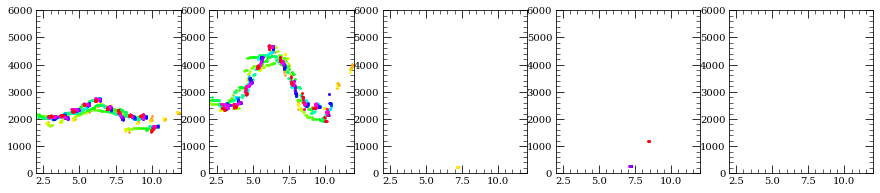

tweezer_num=0, mol_freq_num=8


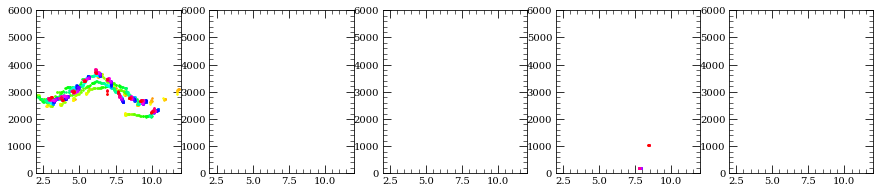

tweezer_num=0, mol_freq_num=9


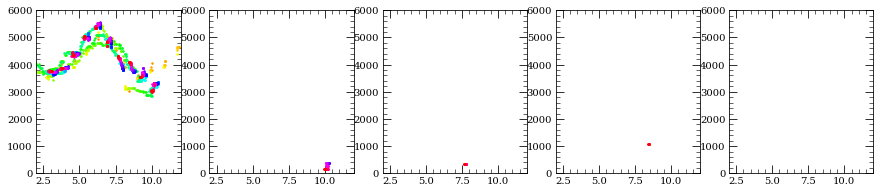

tweezer_num=1, mol_freq_num=0


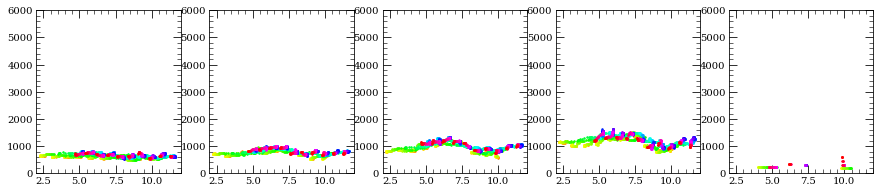

tweezer_num=1, mol_freq_num=1


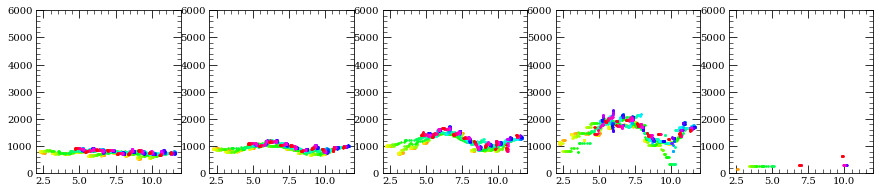

tweezer_num=1, mol_freq_num=2


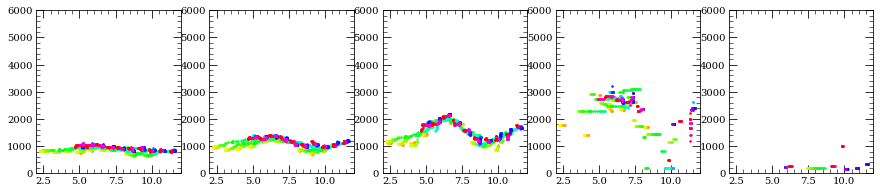

tweezer_num=1, mol_freq_num=3


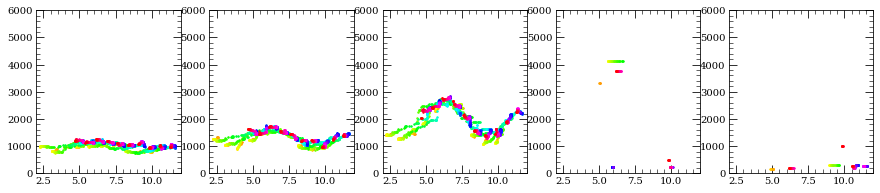

tweezer_num=1, mol_freq_num=4


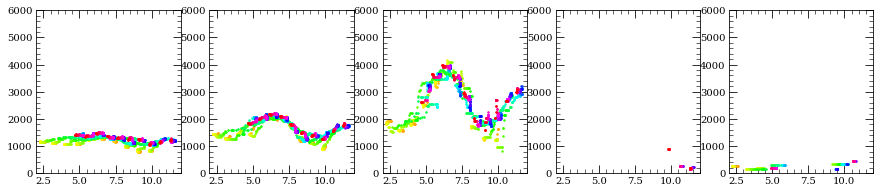

tweezer_num=1, mol_freq_num=5


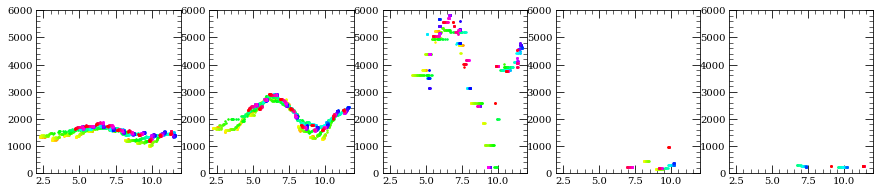

tweezer_num=1, mol_freq_num=6


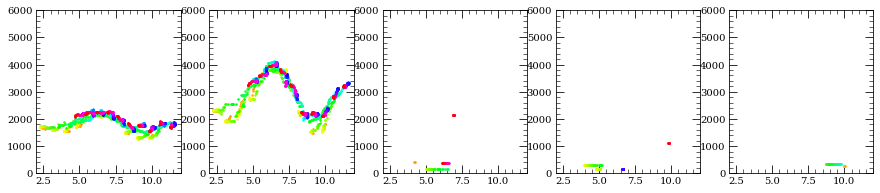

tweezer_num=1, mol_freq_num=7


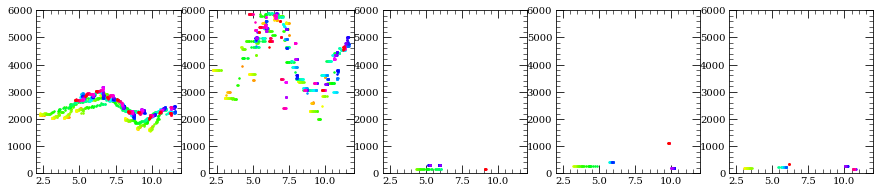

tweezer_num=1, mol_freq_num=8


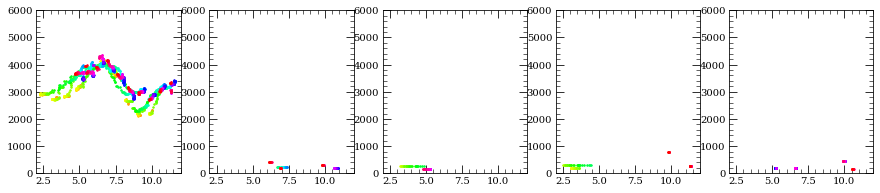

tweezer_num=1, mol_freq_num=9


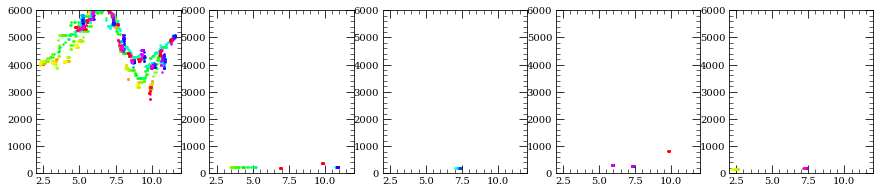

tweezer_num=2, mol_freq_num=0


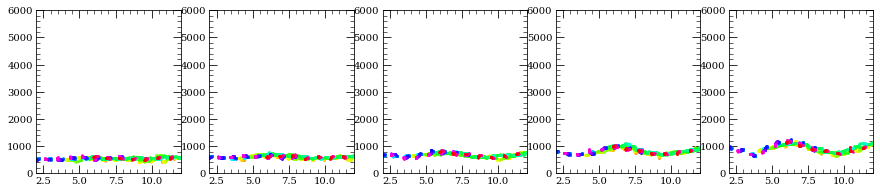

tweezer_num=2, mol_freq_num=1


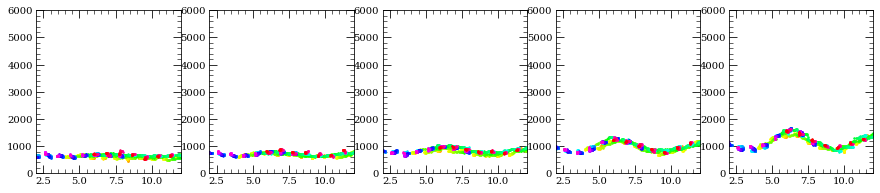

tweezer_num=2, mol_freq_num=2


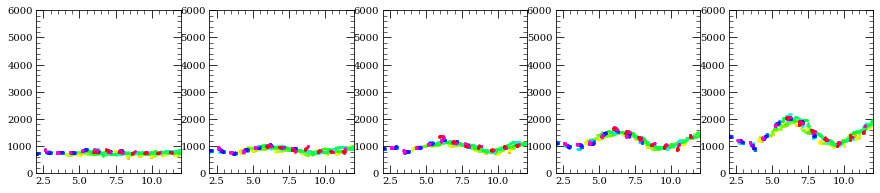

tweezer_num=2, mol_freq_num=3


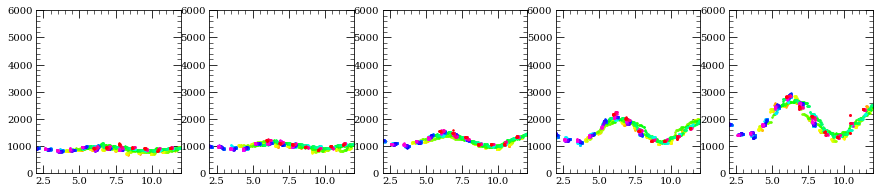

tweezer_num=2, mol_freq_num=4


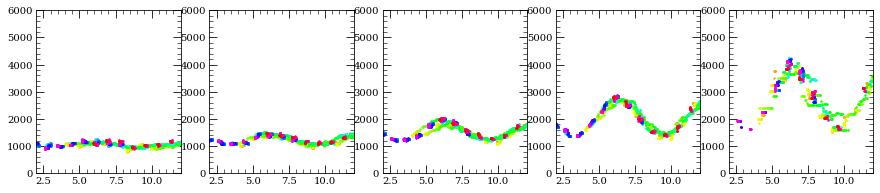

tweezer_num=2, mol_freq_num=5


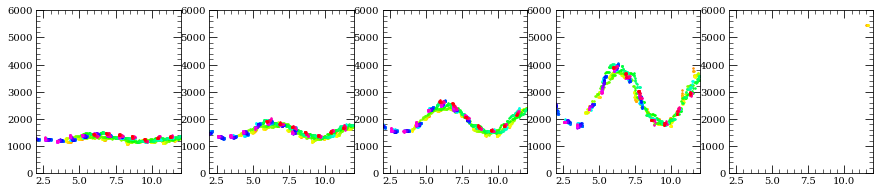

tweezer_num=2, mol_freq_num=6


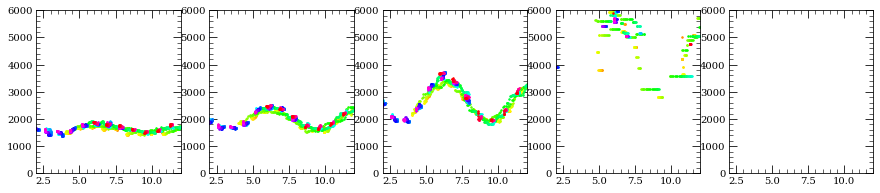

tweezer_num=2, mol_freq_num=7


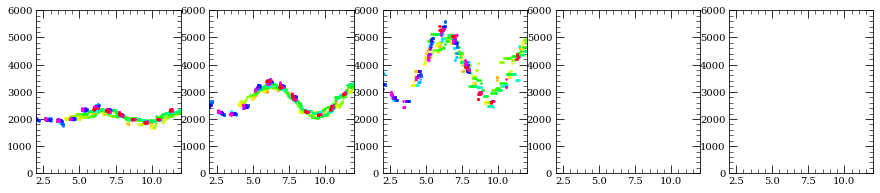

tweezer_num=2, mol_freq_num=8


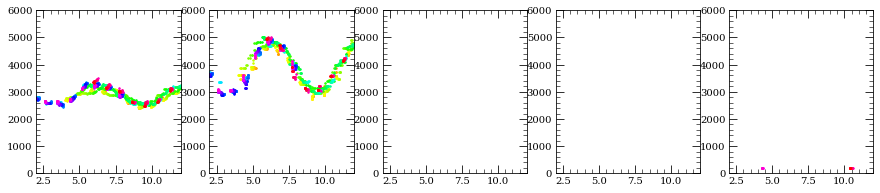

tweezer_num=2, mol_freq_num=9


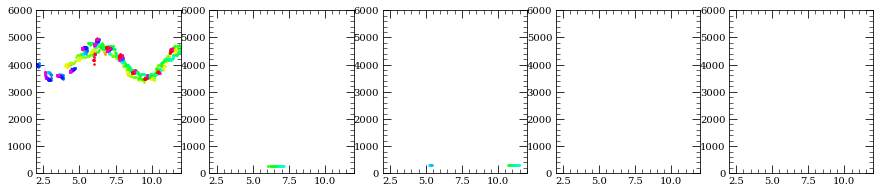

tweezer_num=3, mol_freq_num=0


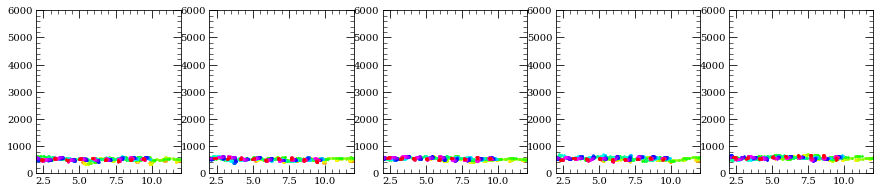

tweezer_num=3, mol_freq_num=1


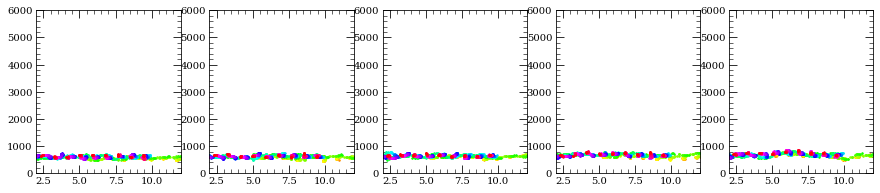

tweezer_num=3, mol_freq_num=2


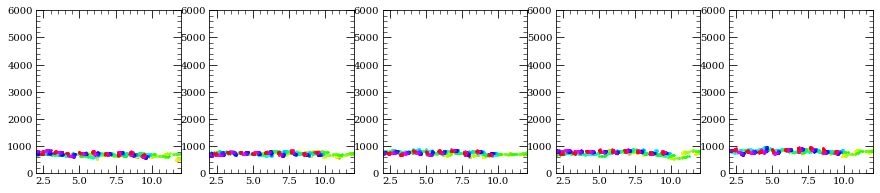

tweezer_num=3, mol_freq_num=3


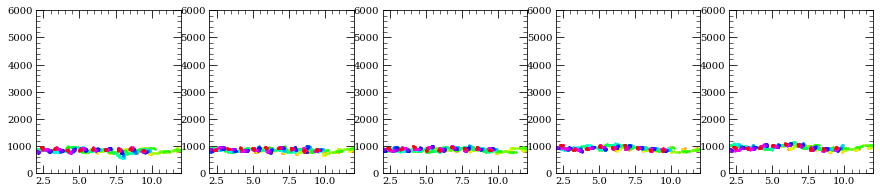

tweezer_num=3, mol_freq_num=4


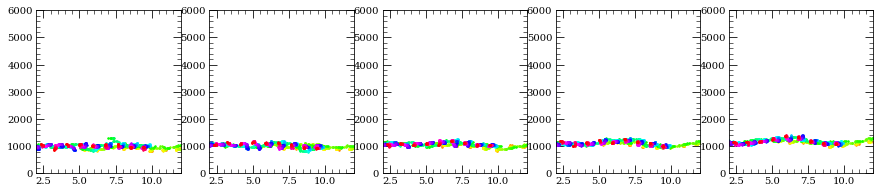

tweezer_num=3, mol_freq_num=5


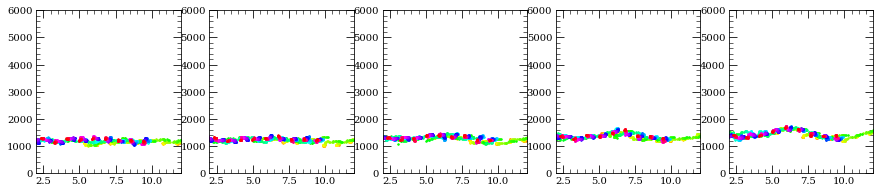

tweezer_num=3, mol_freq_num=6


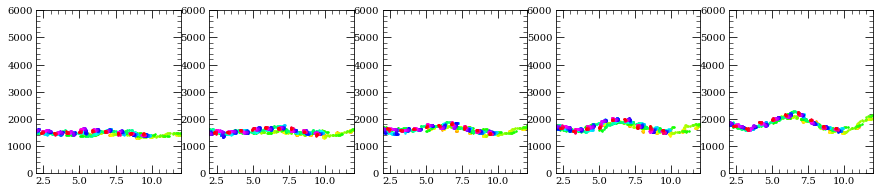

tweezer_num=3, mol_freq_num=7


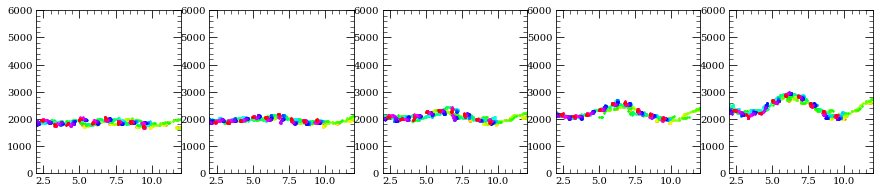

tweezer_num=3, mol_freq_num=8


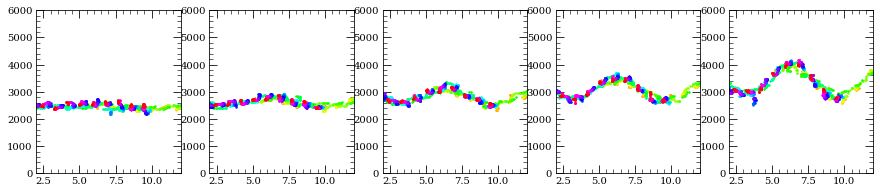

tweezer_num=3, mol_freq_num=9


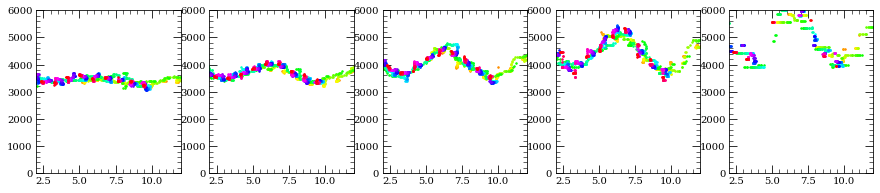

In [26]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size//2)

for tweezer_num in [0, 1, 2, 3]:
    for mol_freq_num in range(num_mol_freq):
        fig = plt.figure(figsize=(num_odt_att * 3, 3))
        print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
        for odt_att_num in range(num_odt_att):
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
            ax = fig.add_subplot(1, num_odt_att, odt_att_num + 1)
            for loop_num in range(rolling_size//2, num_loops-rolling_size//2):
#                 print(loop_num)
                bright_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num)
#                 pzt_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
#                                                       tweezer=tweezer_num, odt_att=odt_att_num).coords['pzt']
                pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
                color = hsv_to_rgb((hue_list[loop_num], 1, 1))
                ax.plot(pzt_data, bright_data, linestyle='none', marker='.', color=color, alpha=1, markersize=3)
                ax.set_ylim(0, 6000)
                ax.set_xlim(2, 12)
        plt.show()

{'f0': 35.68538769369277, 'amp': 4997077.425552836}


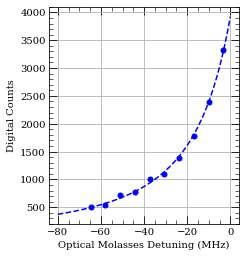

In [27]:
# Reference Inversion
def spectral_func(f, f0, amp):
    return amp /  (f - f0)**2

def inverse_spectral_func(brightness, amp):
    return -np.sqrt(amp / brightness)

def brightness_to_shift(brightness, amp, f_tweezer, f_molasses):
    detuning = inverse_spectral_func(brightness, amp)
    odt_shift = detuning  - f_molasses + 2 * f_tweezer
    return odt_shift


tweezer_num = 4
pzt_num = 0
loop_start = 100
loop_stop = loop_start + 30

fig = plt.figure(figsize=(3.4, 4.0))
ax = fig.add_subplot(1, 1, 1)
red_color = np.linspace(0, 1, num_odt_att)

brightness_data = brightness_xr.isel(tweezer=4, pzt=pzt_num, 
                                     odt_att=odt_att_num,
                                     loop=slice(loop_start, loop_stop)).mean(dim='loop')
brightness_data = brightness_data
freq_data = brightness_data.coords['mol_freq']

mask = np.logical_not(np.isnan(brightness_data))

fit_dict = e6_fit(fit_func=spectral_func, input_data=freq_data[mask], output_data=brightness_data[mask], 
                  param_guess=[30, 1000000], param_keys=['f0', 'amp'])
amp = fit_dict['amp']['val']
f_tweezer = fit_dict['f0']['val'] / 2
sigma_f_tweezer = fit_dict['f0']['std'] / 2
brightness_to_shift_cal = lambda brightness, f_molasses: brightness_to_shift(brightness, amp, f_tweezer, f_molasses)
sigma_brightness_to_sigma_shift_cal = lambda sigma_brightness, brightness, f_molasses: \
np.sqrt((2*sigma_f_tweezer)**2 + (sigma_brightness*inverse_spectral_func(brightness, amp)/2/brightness)**2)
print(fit_dict['kwargs'])
model_freq = np.linspace(-80, 0, 100)
model_brightness = spectral_func(model_freq, **fit_dict['kwargs'])

color = (red_color[odt_att_num], 0, 0)
ax.plot(freq_data, brightness_data, linestyle='none', marker='.', markersize=10, color=(0, 0, 1))
ax.plot(model_freq, model_brightness, color=(0, 0, 1), linestyle='--')
# ax.set_ylim(0, 1000)
ax.set_xlabel(r'Optical Molasses Detuning (MHz)')
ax.set_ylabel('Digital Counts')
ax.grid(True)

tweezer_num=0, mol_freq_num=0


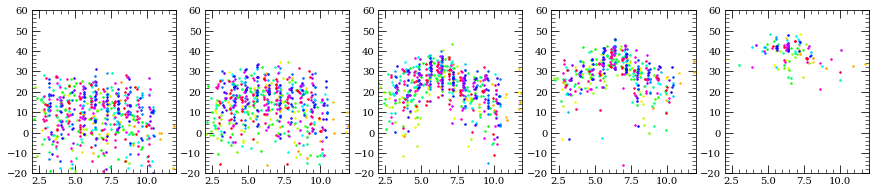

tweezer_num=0, mol_freq_num=1


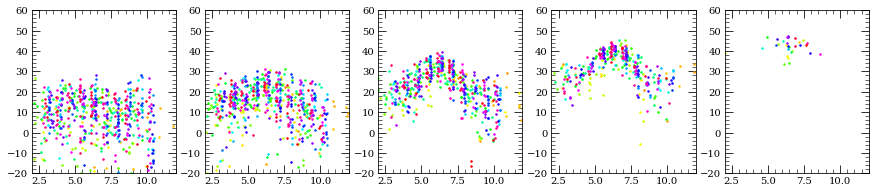

tweezer_num=0, mol_freq_num=2


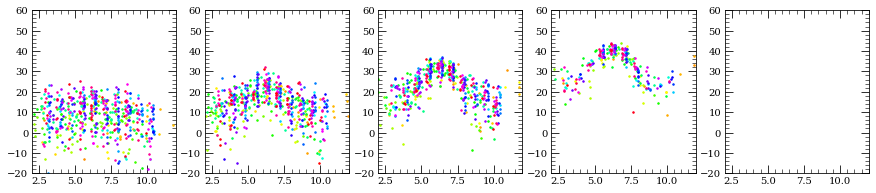

tweezer_num=0, mol_freq_num=3


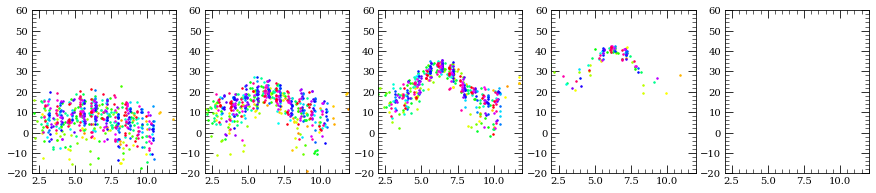

tweezer_num=0, mol_freq_num=4


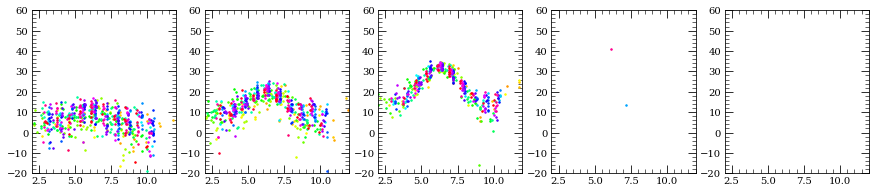

tweezer_num=0, mol_freq_num=5


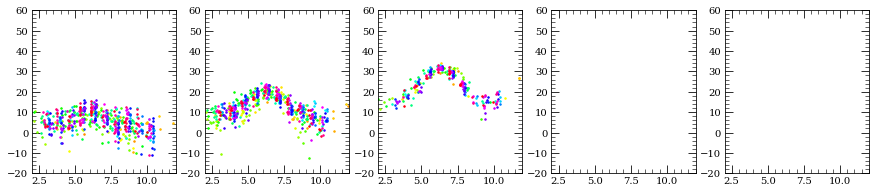

tweezer_num=0, mol_freq_num=6


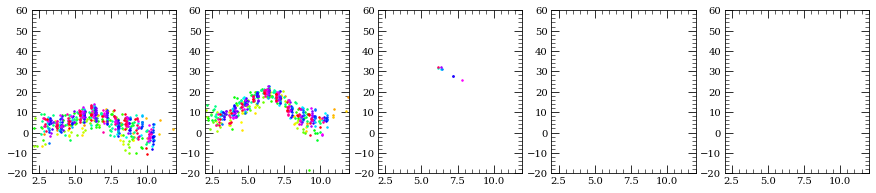

tweezer_num=0, mol_freq_num=7


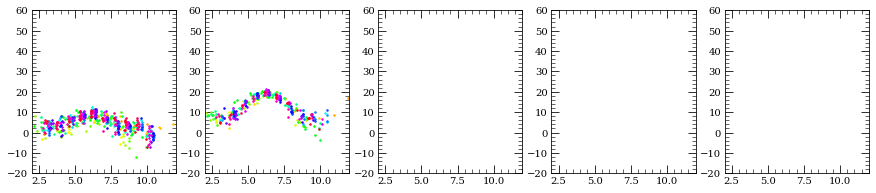

tweezer_num=0, mol_freq_num=8


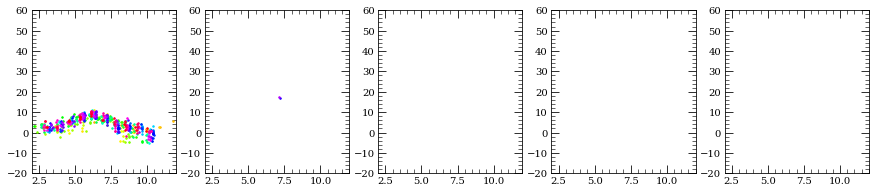

tweezer_num=0, mol_freq_num=9


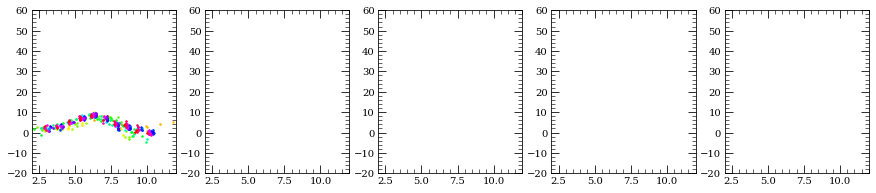

tweezer_num=1, mol_freq_num=0


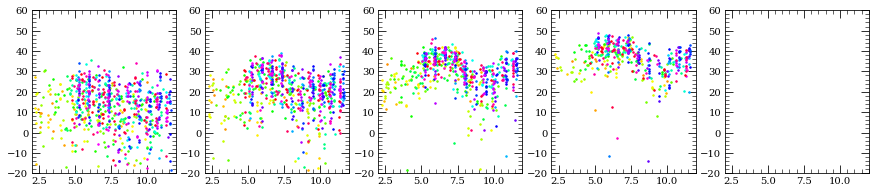

tweezer_num=1, mol_freq_num=1


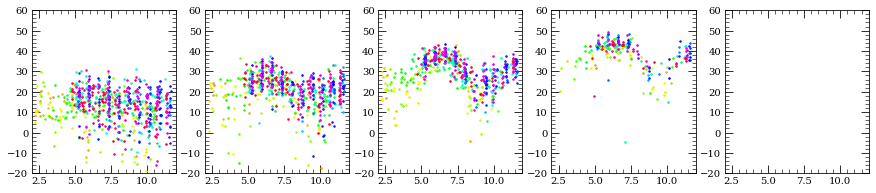

tweezer_num=1, mol_freq_num=2


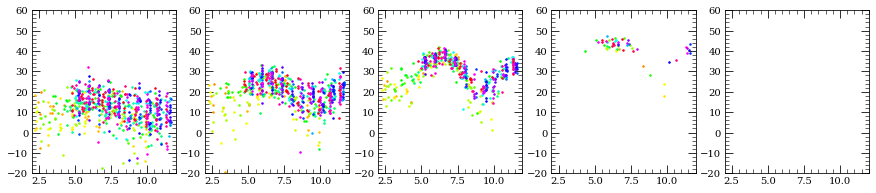

tweezer_num=1, mol_freq_num=3


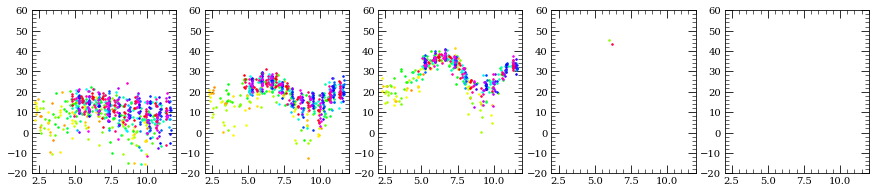

tweezer_num=1, mol_freq_num=4


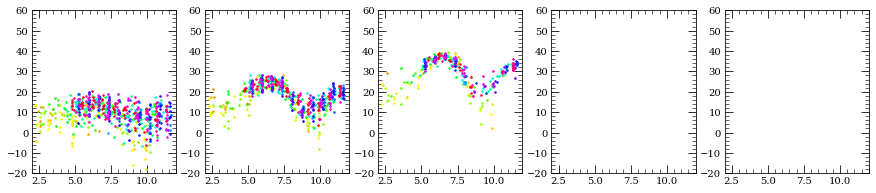

tweezer_num=1, mol_freq_num=5


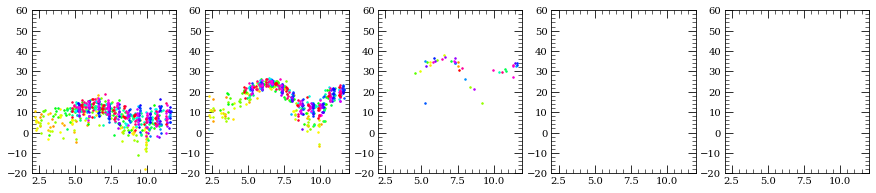

tweezer_num=1, mol_freq_num=6


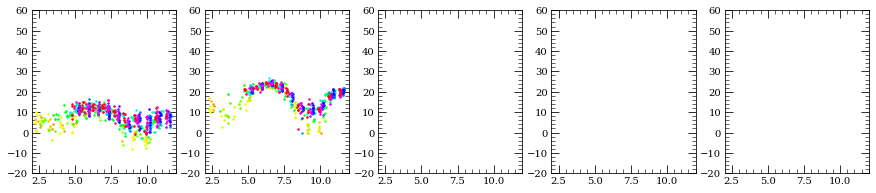

tweezer_num=1, mol_freq_num=7


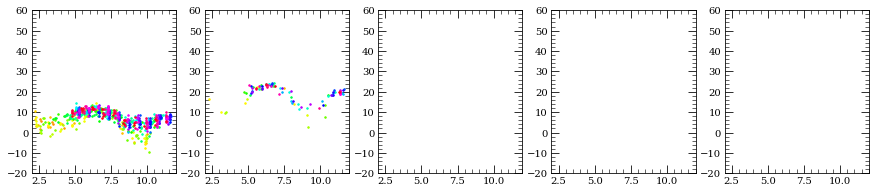

tweezer_num=1, mol_freq_num=8


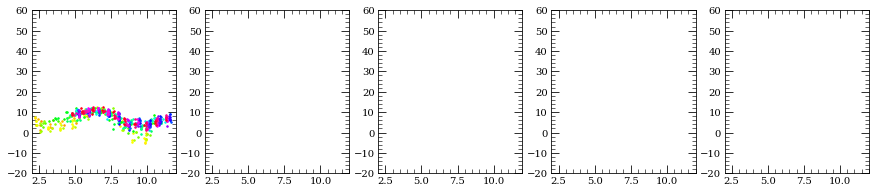

tweezer_num=1, mol_freq_num=9


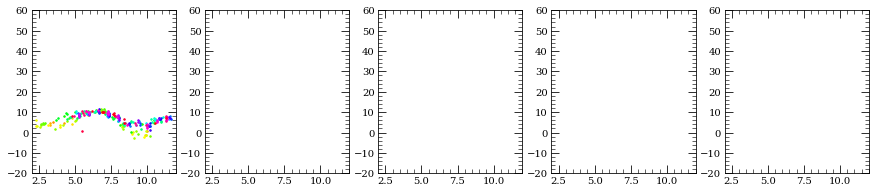

tweezer_num=2, mol_freq_num=0


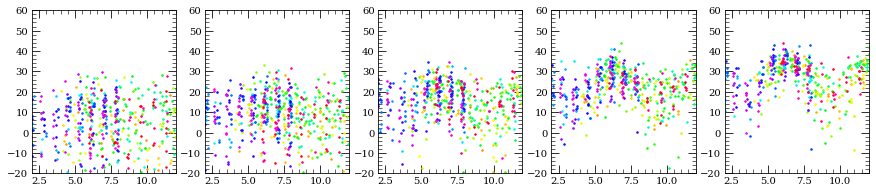

tweezer_num=2, mol_freq_num=1


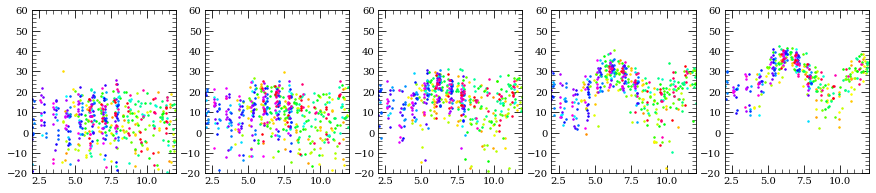

tweezer_num=2, mol_freq_num=2


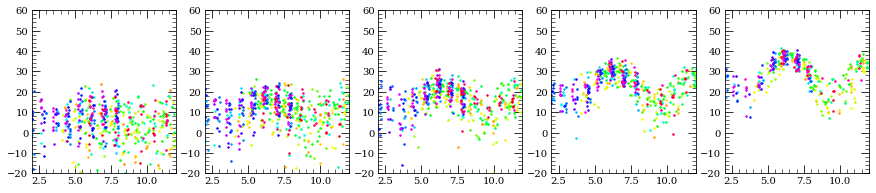

tweezer_num=2, mol_freq_num=3


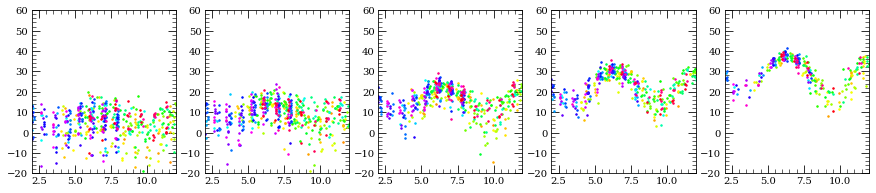

tweezer_num=2, mol_freq_num=4


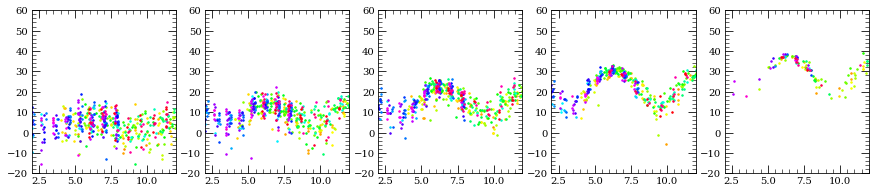

tweezer_num=2, mol_freq_num=5


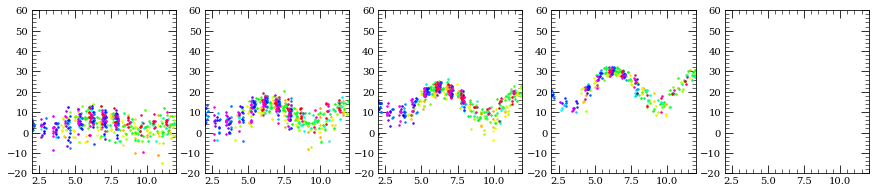

tweezer_num=2, mol_freq_num=6


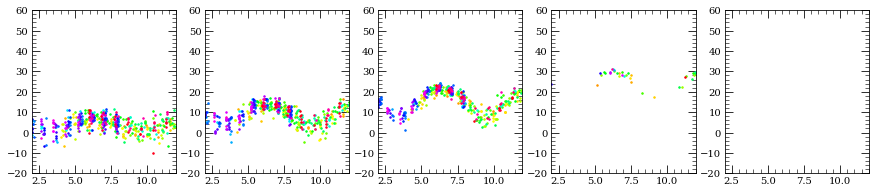

tweezer_num=2, mol_freq_num=7


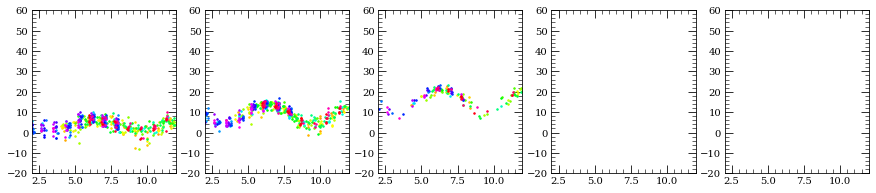

tweezer_num=2, mol_freq_num=8


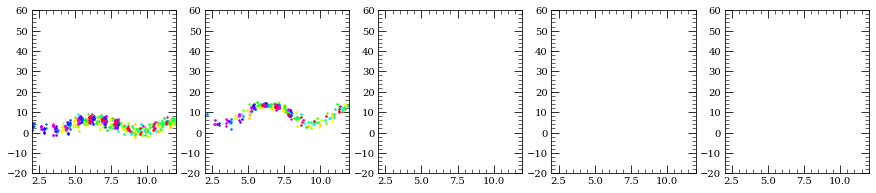

tweezer_num=2, mol_freq_num=9


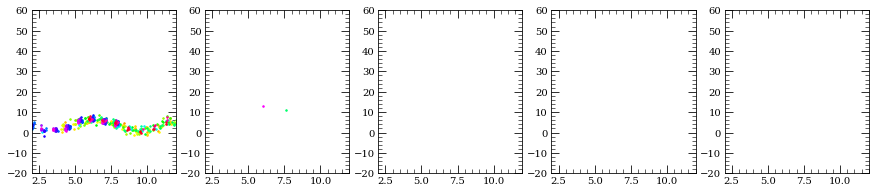

tweezer_num=3, mol_freq_num=0


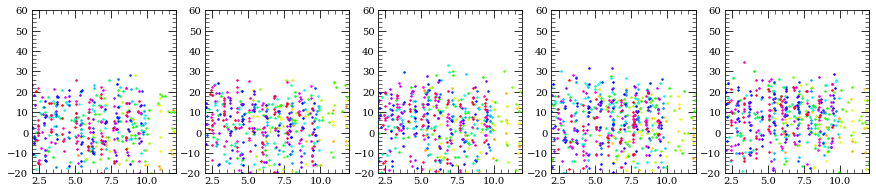

tweezer_num=3, mol_freq_num=1


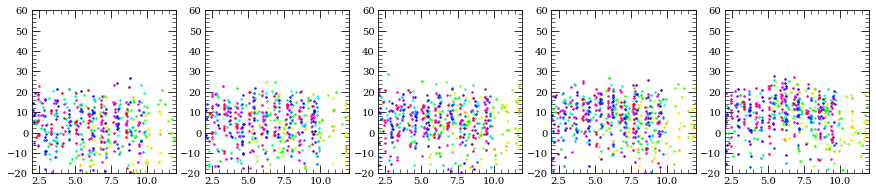

tweezer_num=3, mol_freq_num=2


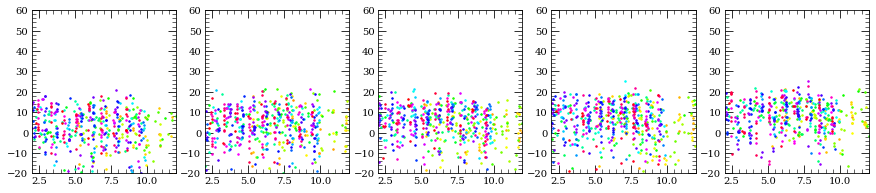

tweezer_num=3, mol_freq_num=3


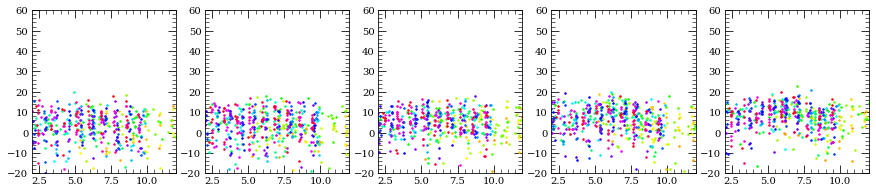

tweezer_num=3, mol_freq_num=4


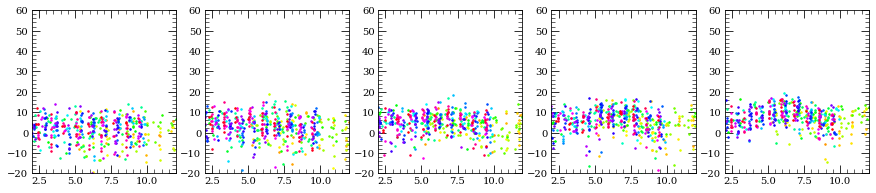

tweezer_num=3, mol_freq_num=5


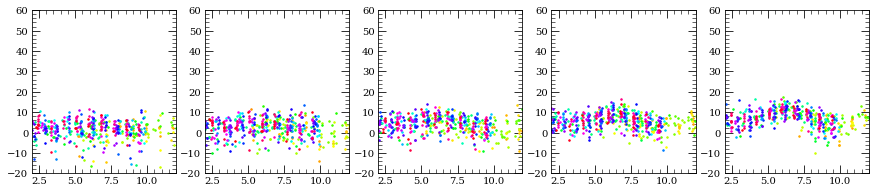

tweezer_num=3, mol_freq_num=6


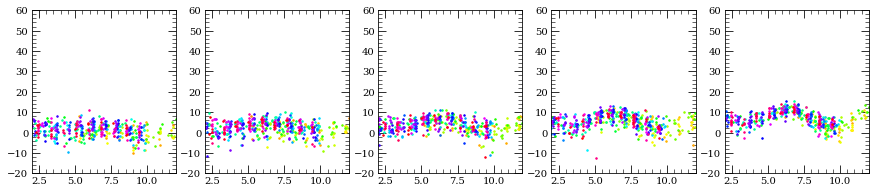

tweezer_num=3, mol_freq_num=7


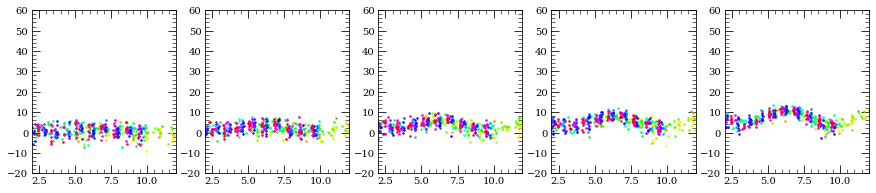

tweezer_num=3, mol_freq_num=8


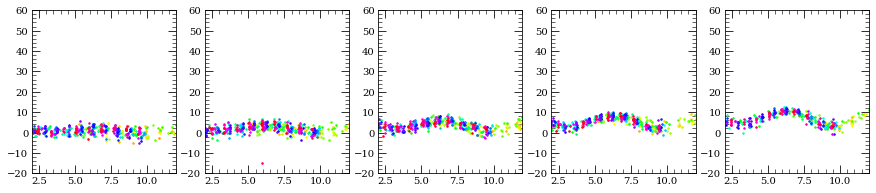

tweezer_num=3, mol_freq_num=9


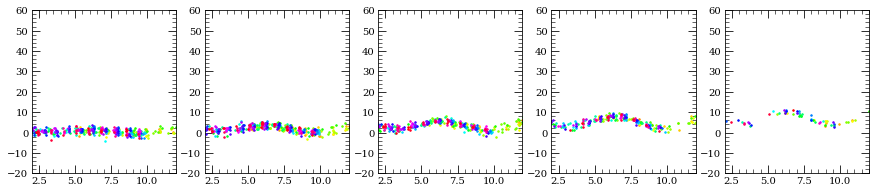

In [28]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size//2)

for tweezer_num in [0, 1, 2, 3]:
    for mol_freq_num in range(num_mol_freq):
        fig = plt.figure(figsize=(num_odt_att * 3, 3))
        print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
        for odt_att_num in range(num_odt_att):
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
            ax = fig.add_subplot(1, num_odt_att, odt_att_num + 1)
#             for loop_num in range(num_loops-rolling_size):
            for loop_num in range(rolling_size//2, num_loops-rolling_size//2):
#                 print(loop_num)
                bright_data = brightness_xr.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num)
                shift_data = brightness_to_shift_cal(bright_data, mol_freq_list[mol_freq_num])
                pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
                color = hsv_to_rgb((hue_list[loop_num], 1, 1))
                ax.plot(pzt_data, shift_data, linestyle='none', marker='.', color=color, alpha=1, markersize=3)
                ax.set_ylim(-20, 60)
                ax.set_xlim(2, 12)
        plt.show()

tweezer_num=0, mol_freq_num=0


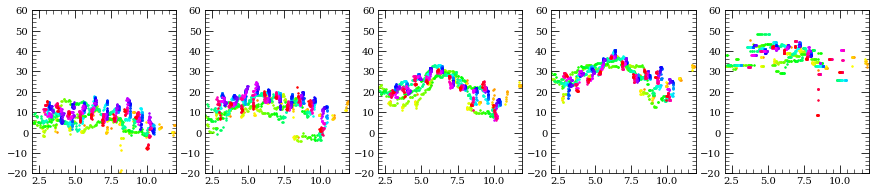

tweezer_num=0, mol_freq_num=1


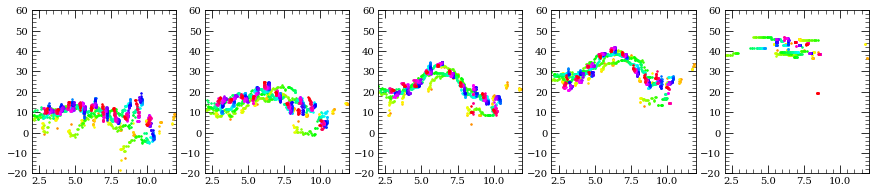

tweezer_num=0, mol_freq_num=2


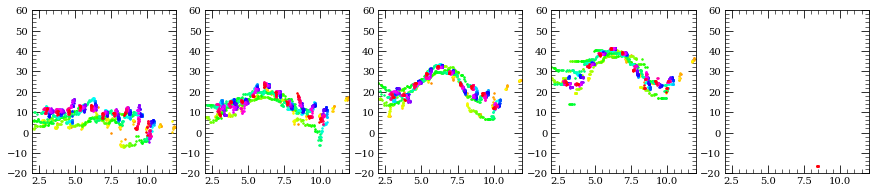

tweezer_num=0, mol_freq_num=3


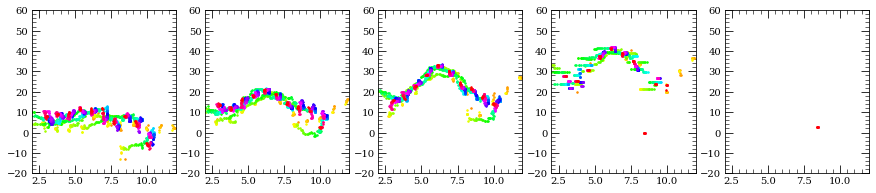

tweezer_num=0, mol_freq_num=4


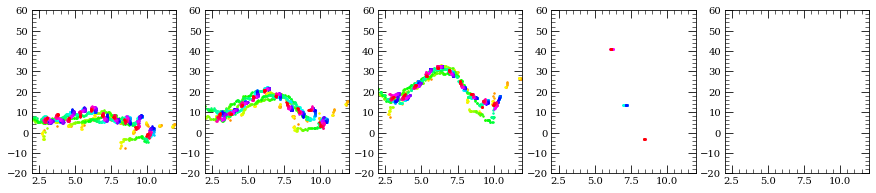

tweezer_num=0, mol_freq_num=5


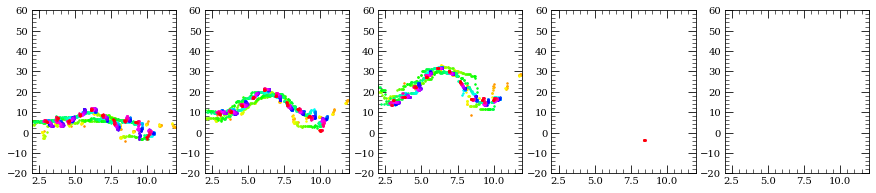

tweezer_num=0, mol_freq_num=6


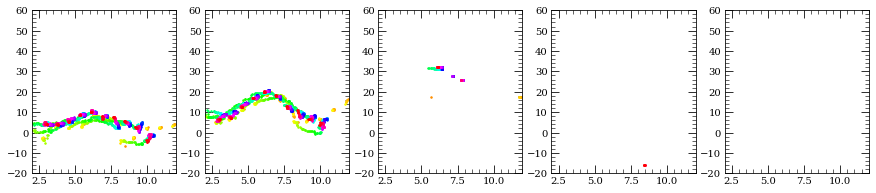

tweezer_num=0, mol_freq_num=7


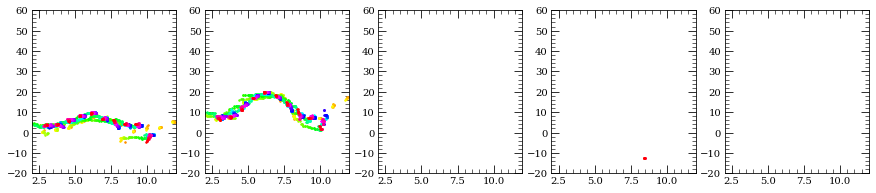

tweezer_num=0, mol_freq_num=8


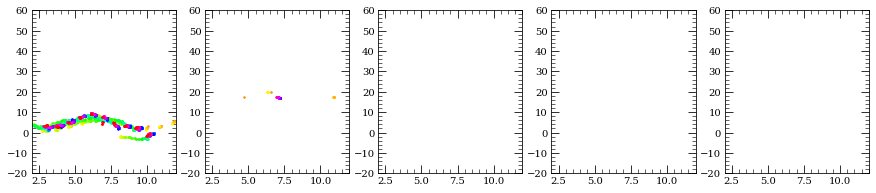

tweezer_num=0, mol_freq_num=9


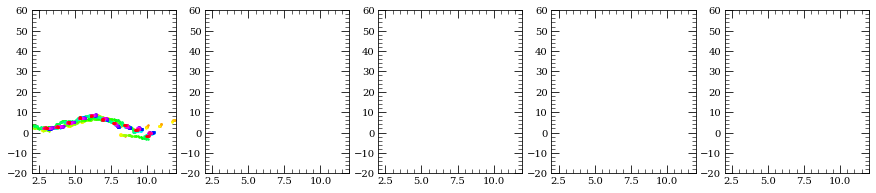

tweezer_num=1, mol_freq_num=0


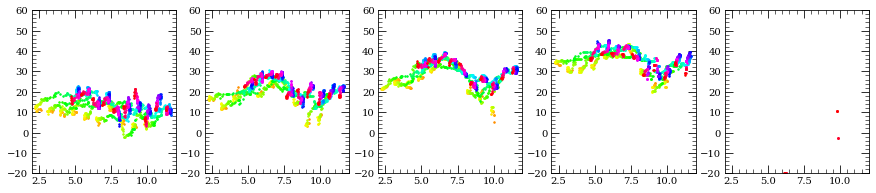

tweezer_num=1, mol_freq_num=1


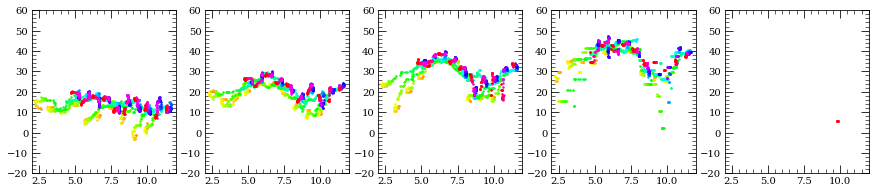

tweezer_num=1, mol_freq_num=2


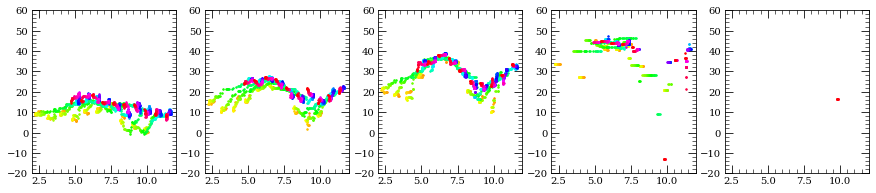

tweezer_num=1, mol_freq_num=3


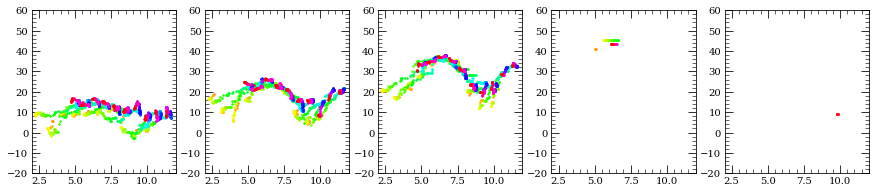

tweezer_num=1, mol_freq_num=4


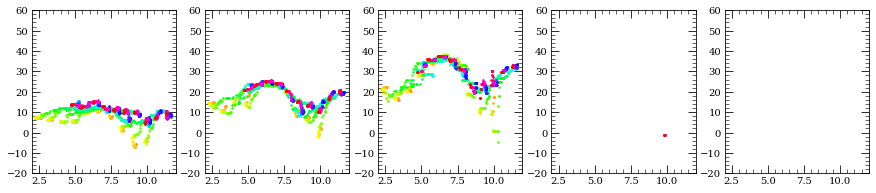

tweezer_num=1, mol_freq_num=5


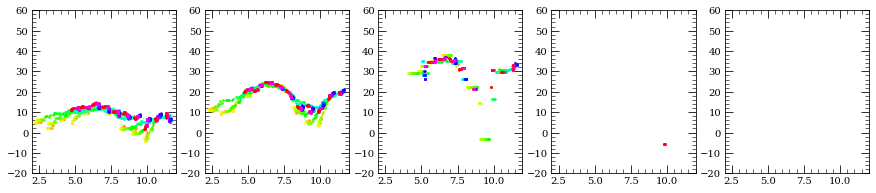

tweezer_num=1, mol_freq_num=6


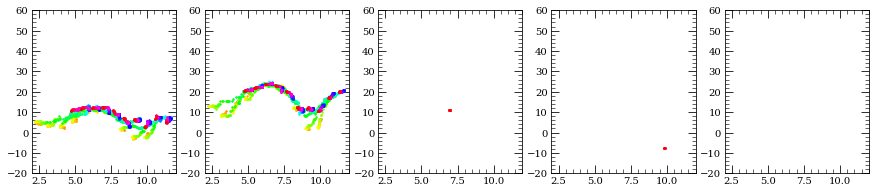

tweezer_num=1, mol_freq_num=7


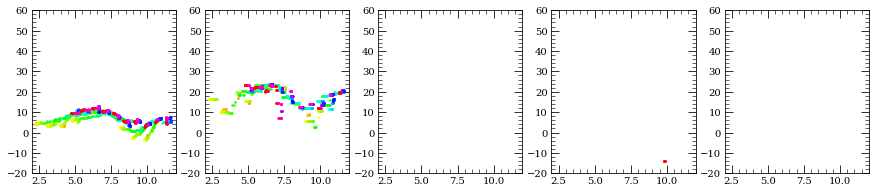

tweezer_num=1, mol_freq_num=8


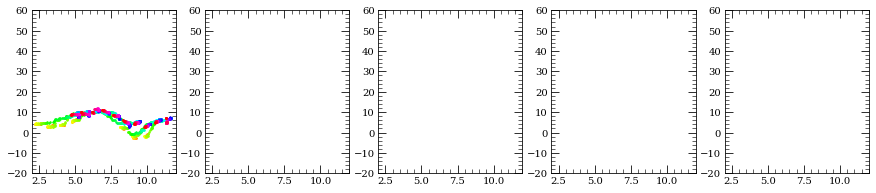

tweezer_num=1, mol_freq_num=9


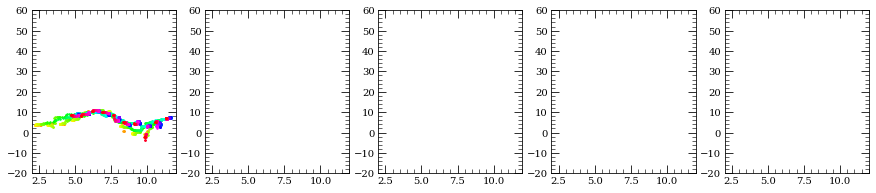

tweezer_num=2, mol_freq_num=0


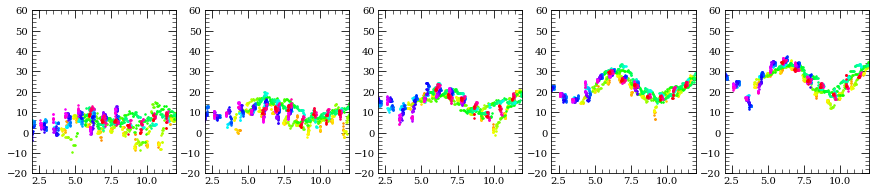

tweezer_num=2, mol_freq_num=1


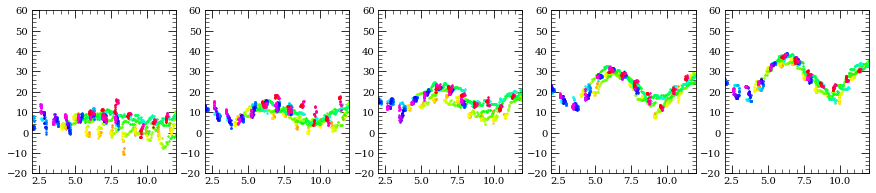

tweezer_num=2, mol_freq_num=2


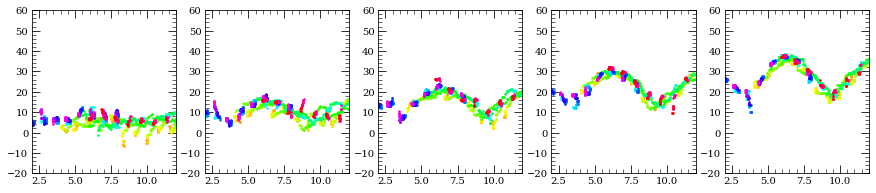

tweezer_num=2, mol_freq_num=3


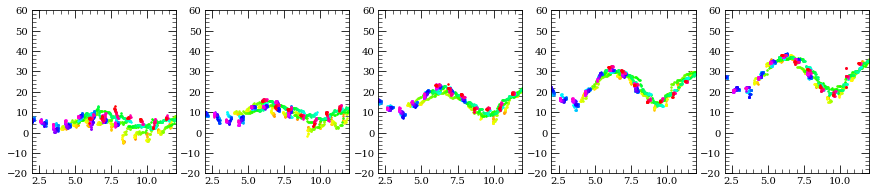

tweezer_num=2, mol_freq_num=4


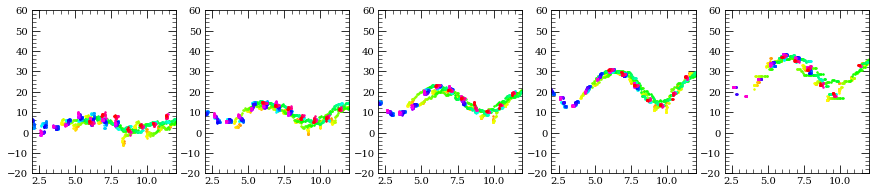

tweezer_num=2, mol_freq_num=5


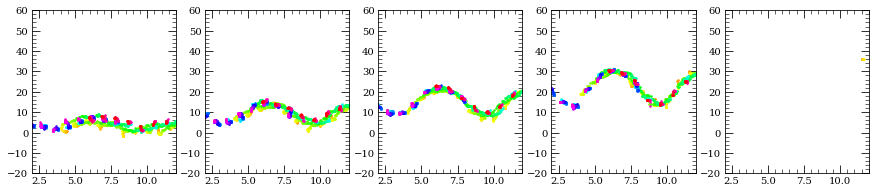

tweezer_num=2, mol_freq_num=6


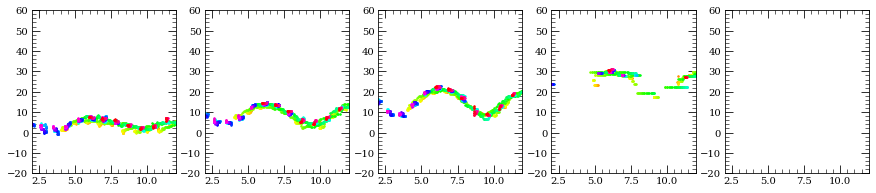

tweezer_num=2, mol_freq_num=7


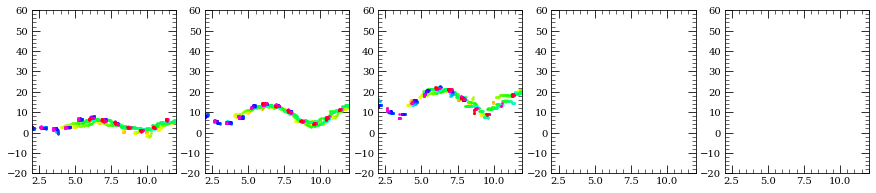

tweezer_num=2, mol_freq_num=8


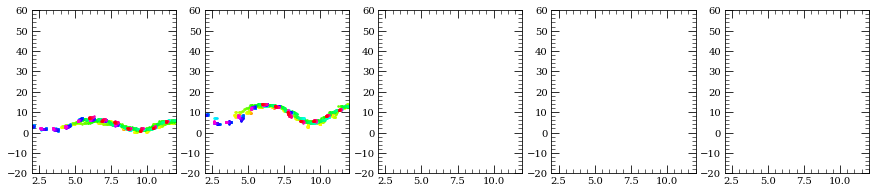

tweezer_num=2, mol_freq_num=9


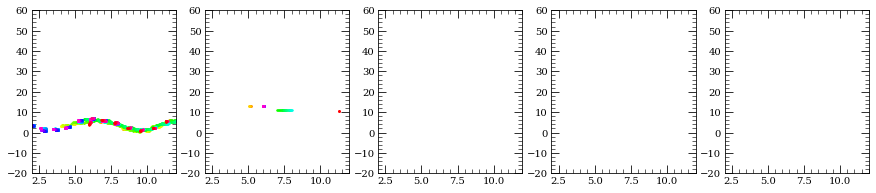

tweezer_num=3, mol_freq_num=0


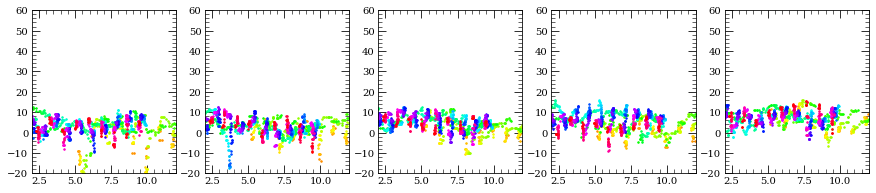

tweezer_num=3, mol_freq_num=1


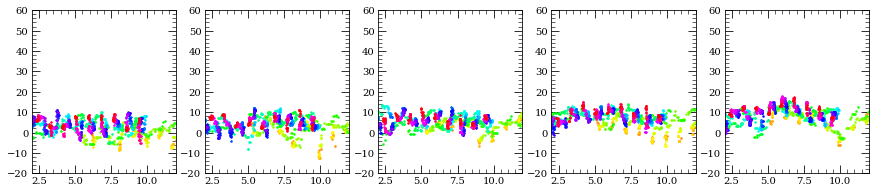

tweezer_num=3, mol_freq_num=2


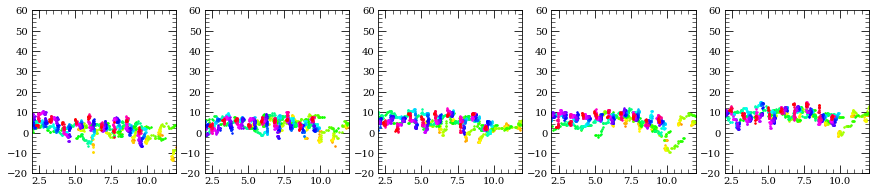

tweezer_num=3, mol_freq_num=3


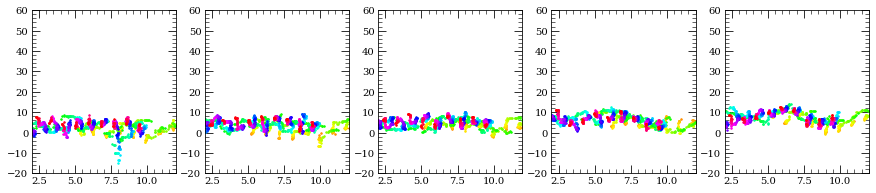

tweezer_num=3, mol_freq_num=4


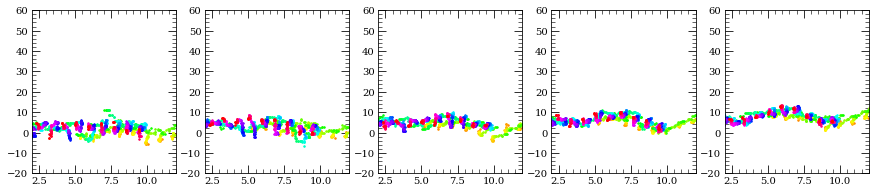

tweezer_num=3, mol_freq_num=5


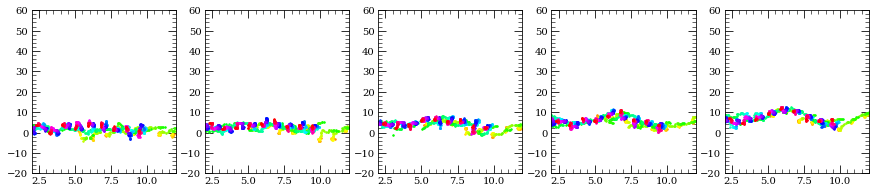

tweezer_num=3, mol_freq_num=6


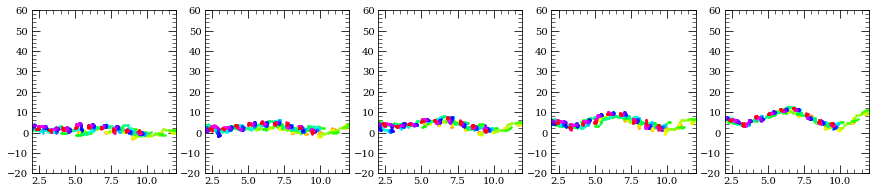

tweezer_num=3, mol_freq_num=7


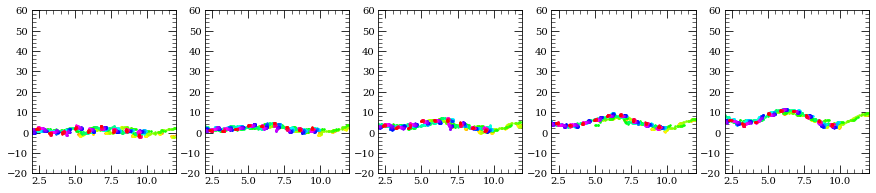

tweezer_num=3, mol_freq_num=8


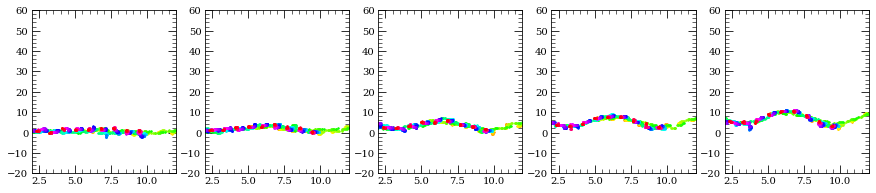

tweezer_num=3, mol_freq_num=9


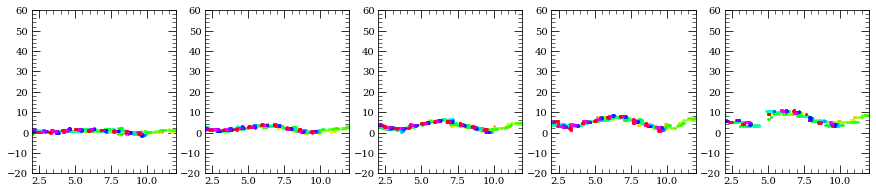

In [29]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size//2)

for tweezer_num in [0, 1, 2, 3]:
    for mol_freq_num in range(num_mol_freq):
        fig = plt.figure(figsize=(num_odt_att * 3, 3))
        print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
        for odt_att_num in range(num_odt_att):
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
            ax = fig.add_subplot(1, num_odt_att, odt_att_num + 1)
#             for loop_num in range(num_loops-rolling_size):
            for loop_num in range(rolling_size//2, num_loops-rolling_size//2):
#                 print(loop_num)
                bright_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num)
                sigma_bright_data = sigma_brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                                      tweezer=tweezer_num, odt_att=odt_att_num)
                shift_data = brightness_to_shift_cal(bright_data, mol_freq_list[mol_freq_num])
                sigma_shift_data = sigma_brightness_to_sigma_shift_cal(sigma_bright_data, bright_data, mol_freq_list[mol_freq_num])
#                 pzt_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
#                                                       tweezer=tweezer_num, odt_att=odt_att_num).coords['pzt']
                pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
                color = hsv_to_rgb((hue_list[loop_num], 1, 1))
                ax.plot(pzt_data, shift_data, linestyle='none', marker='.', color=color, alpha=1, markersize=3)
                ax.set_ylim(-20, 60)
                ax.set_xlim(2, 12)
        plt.show()

In [31]:

# axial_dat_out_list = [["twz0_Axial_Position_dat(um)","twz0_Axial_Stark_shift_dat(MHz)"]]
# for twz in range(1,5):
#     axial_dat_out_list[0].extend([f"twz{twz}_Axial_Position_dat(um)",f"twz{twz}_Axial_Stark_shift_dat(MHz)"])
# axial_dat_out_list.extend(num_pzt*(num_loops-rolling_size)*[['','','','','','','','','','']])
# axial_dat_out_list

01_Radial_Position_dat(um),01_Radial_Stark_shift_dat(MHz),01_sigma_Radial_Stark_shift_dat(MHz)

-53.57809404694238,0.6099412616564268,2.462205412049275

-42.07809404694238,5.284690011115663,0.03445330338104829

-30.578094046942386,13.553808838378147,0.06895441696895889

-19.078094046942386,23.822477992637264,0.04899178476292383

-7.578094046942386,7.795921974073184,0.03848060209720419

3.921905953057614,1.779307537871944,0.039331917743755176

15.421905953057614,17.59532988834193,0.08231444058133397

26.921905953057614,16.638298073859904,0.04715102327206003

38.42190595305762,4.942752048144363,0.0900764562807164

49.92190595305762,1.6936191497702644,0.034653862507992204

[-0.9036436879185613, 0.05266267719147072]
contrast = -0.32482863517533467
[3.685835039859039, 0.0153378836865284]
contrast = 0.550871809637505
[15.778585640342936, 0.02779905826377608]
contrast = 0.3959083331921842
[29.690404649939314, 0.04667413684424066]
contrast = 0.2641319323531999
[23.329266725223864, 0.0380626014

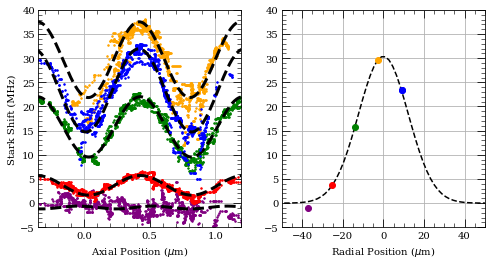

In [34]:
save_data_dir = Path(fig_data_directory)
file_name = 'figure-3b_01_data.txt'
dat_file_path = Path(save_data_dir, file_name)
f = open(dat_file_path, "r")
xxdat_01 = []
yydat_01 = []
yyerr_01 = []
for line in f:
    print(line)
    xxdat_01.append(line[0])
    yydat_01.append(line[1])
    yyerr_01.append(line[2])
    
file_name = 'figure-3b_01_fit.txt'
dat_file_path = Path(save_data_dir, file_name)
f = open(dat_file_path, "r")
xxfit_01 = []
yyfit_01 = []
for line in f:
    xxfit_01.append(line[0])
    yyfit_01.append(line[1])



tweezer_spacing = 5.75*2
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size//2)

fig = plt.figure(figsize=(2 * 4, 4))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
axial_dat_out_list = [["twz0_Axial_Position_dat(um)","twz0_Axial_Stark_shift_dat(MHz)"]]
for twz in range(1,5):
    axial_dat_out_list[0].extend([f"twz{twz}_Axial_Position_dat(um)",f"twz{twz}_Axial_Stark_shift_dat(MHz)"])
axial_dat_out_list.extend(num_pzt*(num_loops-rolling_size)*[['','','','','','','','','','']])
axial_dat_out_list = np.array(axial_dat_out_list)
radial_dat_out_list = [["Radial_Position_dat(um)","Radial_Stark_shift_dat(MHz)","sigma_Radial_Stark_shift_dat(MHz)"]]
axial_fit_out_list = [["twz0_Axial_Position_dat(um)","twz0_Axial_Stark_shift_dat(MHz)"]]
for twz in range(1,5):
    axial_fit_out_list[0].extend([f"twz{twz}_Axial_Position_dat(um)",f"twz{twz}_Axial_Stark_shift_dat(MHz)"])
axial_fit_out_list.extend(num_pzt*(num_loops-rolling_size)*[['','','','','','','','','','']])
axial_fit_out_list = np.array(axial_fit_out_list)
radial_fit_out_list = [["Radial_Position_fit(um)","Radial_Stark_shift_fit(MHz)"]]
mol_freq_num_list = [4, 3, 6, 9, 6]
color_list = ['blue', 'orange', 'green', 'red', 'purple']
offset_list = []
offset_err_list = []
for tweezer_counter, tweezer_num in enumerate([4,3,2,1,0]):
    mol_freq_num = mol_freq_num_list[tweezer_num]
#     print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
    odt_att_num = 2
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
#             for loop_num in range(num_loops-rolling_size):
    shift_data_tot = []
    sigma_shift_data_tot = []
    pzt_data_tot = []
    for loop_num in range(rolling_size//2, num_loops-rolling_size//2):
#                 print(loop_num)
        bright_data = brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                              tweezer=tweezer_num, odt_att=odt_att_num)

        sigma_bright_data = sigma_brightness_rolling.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                              tweezer=tweezer_num, odt_att=odt_att_num)
        shift_data = brightness_to_shift_cal(bright_data, mol_freq_list[mol_freq_num])
        sigma_shift_data = sigma_brightness_to_sigma_shift_cal(sigma_bright_data, bright_data, mol_freq_list[mol_freq_num])
        shift_data_tot += list(shift_data)
        sigma_shift_data_tot += list(sigma_shift_data)
        if tweezer_num is not 4:
            pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
            pguess = [2*np.pi/10, 0, 5, 10]
        else:
            pzt_data = phase_xr.isel(loop=loop_num, tweezer=3)
            pguess = [4*np.pi/10, 0, 0, 0]
        pzt_data_tot += list(pzt_data)
    
    shift_data_tot = np.array(shift_data_tot)
    sigma_shift_data_tot = np.array(sigma_shift_data_tot)
    pzt_data_tot = np.array(pzt_data_tot)
    
    mask = np.logical_not(np.isnan(np.array(shift_data_tot) ))
    popt, pcov = curve_fit(cos_fit_func, pzt_data_tot[mask], shift_data_tot[mask],\
                           sigma = sigma_shift_data_tot[mask], p0=pguess, maxfev = 100000)
    offset = popt[3]
    offset_list.append(offset)
    offset_err = np.sqrt(pcov[3, 3])
    offset_err_list.append(offset_err)
    print([offset, offset_err])
    print(f'contrast = {np.abs(popt[2])/popt[3]}')
    model_phase = np.linspace(0, 14, 200)
    model_shift = cos_fit_func(model_phase, *popt)
    
    for ii in range(len(shift_data_tot)):
        axial_dat_out_list[ii+1][2*tweezer_counter]=(pzt_data_tot[ii]-3)/10*1.27
        axial_dat_out_list[ii+1][2*tweezer_counter+1]=shift_data_tot[ii]

    for ii in range(len(model_shift)):
        axial_fit_out_list[ii+1][2*tweezer_counter]=(model_phase[ii]-3)/10*1.27
        axial_fit_out_list[ii+1][2*tweezer_counter+1]=model_shift[ii]
#     print(axial_dat_out_list)
    color = color_list[tweezer_num]
    ax.plot((pzt_data_tot-3)/10*1.27, shift_data_tot, linestyle='none', color=color, marker='.', alpha=1, markersize=3)
    ax.plot((model_phase-3)/10*1.27, model_shift, linestyle='--', color='black', alpha=1, linewidth=3)
#     ax2.errorbar(tweezer_counter*4.2*2, offset, \
#                  yerr=offset_err, color=color, linestyle='none', marker='.', markersize=10)
# offset_list.reverse()
ax.set_ylim(-5, 40)
ax.set_xlim(-0.35, 1.2)
ax.grid(True)
ax.set_xlabel('Axial Position ($\mu$m)')
ax.set_ylabel('Stark Shift (MHz)')

popt, pcov = curve_fit(gaussian, [0, 1, 2, 3, 4], offset_list, p0=[1, 5, 1])
print(f'sigma={popt[2]*tweezer_spacing}')
print(f'center={popt[0]*tweezer_spacing}')
model_pos = np.linspace(-8, 8, 100)+popt[0]
model_offset = gaussian(model_pos, *popt)
for tweezer_counter, tweezer_num in enumerate([4,3,2,1,0]):
    radial_dat_out_list.append([(tweezer_counter-popt[0])*tweezer_spacing, offset_list[tweezer_counter], offset_err_list[tweezer_counter]])
    color = color_list[tweezer_num]
    ax2.errorbar((tweezer_counter-popt[0])*tweezer_spacing, offset_list[tweezer_counter], \
                 yerr=offset_err_list[tweezer_counter], color=color, linestyle='none', marker='.', markersize=12)
    
ax2.errorbar((tweezer_counter-popt[0])*tweezer_spacing, offset_list[tweezer_counter], \
                 yerr=offset_err_list[tweezer_counter], color=color, linestyle='none', marker='.', markersize=12)
for ii in range(len(model_offset)):
    radial_fit_out_list.append([(model_pos[ii]-popt[0])*tweezer_spacing, model_offset[ii]])
ax2.plot((model_pos-popt[0])*tweezer_spacing, model_offset, linestyle='--', color='black')
ax2.set_ylim(-5, 40)
ax2.set_xlim(-50, 50)
ax2.grid(True)
ax2.set_xlabel('Radial Position ($\mu$m)')


plt.show()
save_dir = Path(fig_directory)
save_dir.mkdir(parents=True, exist_ok=True)
file_name = f'figure_axialandradial.png'
file_path = Path(save_dir, file_name)
fig.savefig(file_path, dpi=400)
plt.close(fig)


save_data_dir = Path(fig_data_directory)
file_name = 'figure-3a_data.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in axial_dat_out_list:
        csv_writer.writerow(row)
        
file_name = 'figure-3a_fit.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in axial_fit_out_list:
        csv_writer.writerow(row)
        
file_name = 'figure-3b_data.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in radial_dat_out_list:
        csv_writer.writerow(row)
        
file_name = 'figure-3b_fit.txt'
dat_file_path = Path(save_data_dir, file_name)
with open(dat_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in radial_fit_out_list:
        csv_writer.writerow(row)



In [ ]:
print(num_loops)

In [ ]:
from matplotlib.colors import hsv_to_rgb
hue_list = np.linspace(0, 1, num_loops-rolling_size//2)

fig = plt.figure(figsize=(2 * 4, 4))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

mol_freq_num_list = [4, 3, 6, 9, 6]
color_list = ['blue', 'orange', 'green', 'red', 'purple']
offset_list = []
for tweezer_num in [0, 1, 2, 3, 4]:
    mol_freq_num = mol_freq_num_list[tweezer_num]
#     print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}')
    odt_att_num = 2
#             print(f'tweezer_num={tweezer_num}, mol_freq_num={mol_freq_num}, odt_att_num={odt_att_num}')
#             for loop_num in range(num_loops-rolling_size):
    shift_data_tot = []
    pzt_data_tot = []
    for loop_num in range(rolling_size//2, num_loops-rolling_size//2):
#                 print(loop_num)
        bright_data = brightness_xr.isel(loop=loop_num, mol_freq=mol_freq_num, 
                                              tweezer=tweezer_num, odt_att=odt_att_num)
        shift_data = brightness_to_shift_cal(bright_data, mol_freq_list[mol_freq_num])
        shift_data_tot += list(shift_data)
        if tweezer_num is not 4:
            pzt_data = phase_xr.isel(loop=loop_num, tweezer=tweezer_num)
            pguess = [2*np.pi/10, 0, 5, 10]
        else:
            pzt_data = phase_xr.isel(loop=loop_num, tweezer=3)
            pguess = [2*np.pi/10, 0, 0, 0]
        pzt_data_tot += list(pzt_data)
    
    shift_data_tot = np.array(shift_data_tot)
    pzt_data_tot = np.array(pzt_data_tot)
    
    mask = np.logical_not(np.isnan(np.array(shift_data_tot) ))
    popt, pcov = curve_fit(cos_fit_func, pzt_data_tot[mask], shift_data_tot[mask], p0=pguess)
    offset = popt[3]
    offset_list.append(offset)
    offset_err = np.sqrt(pcov[3, 3])
    print(f'contrast = {np.abs(popt[2])/popt[3]}')
    print([offset, offset_err])
    model_phase = np.linspace(0, 14, 200)
    model_shift = cos_fit_func(model_phase, *popt)
    
    color = color_list[tweezer_num]
    ax.plot((pzt_data_tot-2)/10*2, shift_data_tot, linestyle='none', color=color, marker='.', alpha=1, markersize=3)
    ax.plot((model_phase-2)/10*2, model_shift, linestyle='--', color='black', alpha=1, linewidth=3)
    ax2.errorbar(tweezer_num*5.75*2, offset, \
                 yerr=offset_err, color=color, linestyle='none', marker='.', markersize=10)
    
ax.set_ylim(-5, 40)
ax.set_xlim(-0.5, 2)
ax.grid(True)
ax.set_xlabel('Phase Along Lattice ($\pi$)')
ax.set_ylabel('Stark Shift (MHz)')

popt, pcov = curve_fit(gaussian, [0, 1, 2, 3, 4], offset_list, p0=[1, 5, 1])
print(f'sigma={popt[2]*5.75*2}')
model_pos = np.linspace(-1, 4, 100)
model_offset = gaussian(model_pos, *popt)
# ax2.plot(model_pos*4.2*2, model_offset, linestyle='--', color='black')
ax2.set_ylim(-5, 40)
ax2.grid(True)
ax2.set_xlabel('Radial Position ($\mu$m)')


plt.show()




In [46]:
def tweezer_freq_to_radial_position(freq):
    return ((freq-116)*5.75+37.06)

In [49]:
tweezer_freq_to_radial_position(109)

-3.1899999999999977